# Personalized User-level DP

In [1]:
from autodp import rdp_acct
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools

import os
path_project = os.path.dirname(os.path.abspath('.'))
import sys
sys.path.append(os.path.join(path_project, 'src'))
sys.path.append(os.path.join(path_project, 'exp/script'))

import options

img_path = os.path.join(path_project, 'exp', 'img')
pickle_path = os.path.join(path_project, 'exp', 'pickle')
results_path = os.path.join(path_project, 'exp', 'results')
default_args = options.build_default_args(path_project)

import copy
from run_simulation import run_simulation

from mylogger import logger_set_debug, logger_set_info, logger_set_warning
from opacus.accountants import RDPAccountant

import pickle

def RDP_gaussian_with_C(sigma, alpha, C):
    assert(sigma > 0)
    assert(alpha >= 0)
    return 0.5 * C**2 / sigma ** 2 * alpha

### utils

In [2]:
Q_LIST_SIZE = 30

# binary search given q_u
def from_q_u(q_u, delta, epsilon_u, sigma, T, m=100, precision=1e-6):
    max_sensitivity_u = 100
    min_sensitivity_u = 0
    while True:
        sensitivity_u = (max_sensitivity_u + min_sensitivity_u) / 2
        # func_gaussian = lambda x: RDP_gaussian_with_C(sigma, x, sensitivity_u)
        # accountant = rdp_acct.anaRDPacct(m=m)
        accountant = RDPAccountant()
        for i in range(T):
            accountant.step(noise_multiplier=sigma/sensitivity_u, sample_rate=q_u)
            # accountant.compose_subsampled_mechanisms_lowerbound(func=func_gaussian, prob=q_u)
        # eps = accountant.get_eps(delta)
        eps = accountant.get_epsilon(delta=delta)
        if eps < epsilon_u:
            min_sensitivity_u = sensitivity_u
        else:
            max_sensitivity_u = sensitivity_u
        if 0 < epsilon_u - eps and epsilon_u - eps < precision:
            return sensitivity_u, eps


# binary search given_sensitivity_u
def from_sensitivity_u(sensitivity_u, delta, epsilon_u, sigma, T, m=100, precision=1e-6):
    max_q_u = 1.0
    min_q_u = 0
    # func_gaussian = lambda x: RDP_gaussian_with_C(sigma, x, sensitivity_u)
    while True:
        q_u = (max_q_u + min_q_u) / 2
        # accountant = rdp_acct.anaRDPacct(m=m)
        accountant = RDPAccountant()
        for i in range(T):
            # accountant.compose_subsampled_mechanisms_lowerbound(func=func_gaussian, prob=q_u)
            accountant.step(noise_multiplier=sigma/sensitivity_u, sample_rate=q_u)
        # eps = accountant.get_eps(delta)
        eps = accountant.get_epsilon(delta=delta)
        if eps < epsilon_u:
            min_q_u = q_u
        else:
            max_q_u = q_u
        if 0 < epsilon_u - eps and epsilon_u - eps < precision:
            return q_u, eps
        

# qCカーブを書くために，適当にqを選んでCを計算して点をプロットする
def make_q_c_curve(epsilon_u, delta, sigma, n_round=100, num_points=20, min=-5):
    T = n_round

    num_points = num_points // 3 * 2
    x = np.logspace(min, -1, num_points).tolist() + np.linspace(0.15, 1.0, int(num_points/2)).tolist()
    y = []
    for q_u in x:
        sensitivity_u, eps = from_q_u(q_u=q_u, delta=delta, epsilon_u=epsilon_u, sigma=sigma, T=T)
        assert eps <= epsilon_u, f"eps={eps} > epsilon_u={epsilon_u}"
        # print("sensitivity_u =", sensitivity_u, "eps =", eps)
        y.append(sensitivity_u)
    return x, y


def plot_q_c_curve(x, y, title="", log=True):
    fig = plt.figure(figsize=(7, 5))
    ax = fig.add_subplot(111)
    ax.plot(x, y, marker='o', label='sensitivity_u')
    for i, (xi, yi) in enumerate(zip(x, y)):
        if i % 5 == 0:
            ax.annotate(f"({xi:.5f}, {yi:.5f})", (xi, yi), textcoords="offset points", xytext=(0,10), ha='center')
    # q*C の値をプロット
    ax.plot(x, np.array(x)*np.array(y), marker='x', linestyle='--', color='red', label='product_x*y')
    print("Max idx", np.argmax(np.array(x)*np.array(y)))
    if log:
        ax.set_xscale("log")
        ax.set_yscale("log")
    ax.set_xlabel("q_u")
    ax.set_ylabel("sensitivity_u")
    ax.set_title(title)
    plt.show()


def make_static_params(epsilon_u_dct, delta, sigma, n_round, idx_per_group, q_step_size):
    """
    Need to specify idx and q_step_size
    """
    C_u_dct = {}
    q_u_dct = {}

    C_and_q_per_group = {}
    for group_eps, idx in idx_per_group.items():
        n_of_q_u = Q_LIST_SIZE
        q_u_list = []
        init_q_u = 1.0
        for _ in range(n_of_q_u):
            q_u_list.append(init_q_u)
            init_q_u *= q_step_size
        q_u = q_u_list[idx]
        C_u, _eps = from_q_u(q_u=q_u, delta=delta, epsilon_u=group_eps, sigma=sigma, T=n_round)
        assert _eps <= group_eps, f"_eps={_eps} > eps_u={group_eps}"
        C_and_q_per_group[group_eps] = (C_u, q_u)

    for user_id, eps_u in epsilon_u_dct.items():
        C_u, q_u = C_and_q_per_group[eps_u]
        C_u_dct[user_id] = C_u
        q_u_dct[user_id] = q_u

    return C_u_dct, q_u_dct


def fed_simulation(
    delta, 
    sigma, 
    n_users, 
    C_u=None, 
    q_u=None, 
    q_step_size=None,
    times=1, 
    user_dist="uniform-iid", 
    silo_dist="uniform", 
    dataset_name="light_mnist", 
    global_learning_rate=10.0, 
    clipping_bound=1.0,
    n_round=10, 
    local_epochs=50, 
    local_learning_rate=0.01,
    agg_strategy="PULDP-AVG",
    epsilon_u=None,
    group_thresholds=None,
    validation_ratio=0.0,
    with_momentum=None,
    train_loss_dp=None,
    sigma_for_online_optimization=1.0,
    total_dp_eps_for_online_optimization=None,
):
    args = options.build_default_args(path_project)

    if dataset_name == "heart_disease":
        from flamby_utils.heart_disease import update_args

        args = update_args(args)

    elif dataset_name == "tcga_brca":
        from flamby_utils.tcga_brca import update_args

        args = update_args(args)

    args.dataset_name = dataset_name
    args.agg_strategy = agg_strategy
    args.n_total_round = n_round
    args.n_users = n_users
    args.local_epochs = local_epochs
    args.times = times

    args.user_dist = user_dist
    args.silo_dist = silo_dist
    args.global_learning_rate = global_learning_rate
    args.local_learning_rate = local_learning_rate
    args.clipping_bound = clipping_bound
    args.with_momentum = with_momentum
    args.train_loss_dp = train_loss_dp
    args.momentum_weight = q_step_size
    args.sigma_for_online_optimization = sigma_for_online_optimization
    args.total_dp_eps_for_online_optimization = total_dp_eps_for_online_optimization

    args.delta = delta
    args.sigma = sigma
    args.C_u = C_u
    args.q_u = q_u
    args.q_step_size = q_step_size
    args.epsilon_u = epsilon_u
    args.group_thresholds = group_thresholds
    args.dry_run = False
    args.secure_w = False

    args.validation_ratio = validation_ratio

    results_list = []
    for i in range(args.times):
        # print("======== TIME:", i, "start")
        args.seed = args.seed + i
        try:
            sim_results = run_simulation(args, path_project)
            results_list.append(sim_results)
        except OverflowError:
            results_list.append("LOSS IS NAN")
        except AssertionError:
            results_list.append("Assertion Error")

    return results_list


def calc_metric(results, symbol="test"):
    if symbol == "train":
        acc_list = np.array([r['train'][f'train_metric'] for r in results])
        loss_list = np.array([r['train'][f'train_loss'] for r in results])
    else:
        acc_list = np.array([r['global'][f'global_{symbol}'][-1][1] for r in results])
        loss_list = np.array([r['global'][f'global_{symbol}'][-1][2] for r in results])
    acc_mean, acc_std, loss_mean, loss_std = np.mean(acc_list), np.std(acc_list), np.mean(loss_list), np.std(loss_list)
    return acc_mean, acc_std, loss_mean, loss_std


def make_epsilon_u(epsilon=1.0, n_users=0, dist="homo", epsilon_list=[], ratio_list=[], random_state: np.random.RandomState=None) -> dict[int, float]:
    if dist == "homo":
        epsilon_u = {user_id: epsilon for user_id in range(n_users)}
    elif dist == "hetero":
        assert len(epsilon_list) > 0 and len(ratio_list) > 0
        epsilon_u_list = random_state.choice(epsilon_list, size=n_users, p=ratio_list)
        epsilon_u = {user_id: epsilon_u_list[user_id] for user_id in range(n_users)}
    else:
        raise ValueError(f"invalid dist {dist}")
    return epsilon_u

def group_by_closest_below(epsilon_u_dct: dict, group_thresholds: list):
    minimum = min(epsilon_u_dct.values())
    group_thresholds = set(group_thresholds) | {minimum}
    grouped = {
        g: [] for g in group_thresholds
    }  # Initialize the dictionary with empty lists for each group threshold
    for key, value in epsilon_u_dct.items():
        # Find the closest group threshold that is less than or equal to the value
        closest_group = max([g for g in group_thresholds if g <= value], default=None)
        # If a suitable group is found, append the key to the corresponding list
        if closest_group is not None:
            grouped[closest_group].append(key)

    return grouped


## STATIC MANUAL OPTIMIZATION

def prepare_grid_search(epsilon_u, start_idx: int, end_idx: int):
    # set idx list for each group
    group_eps_set = set(epsilon_u.values())
    idx_per_group_list = []

    idx_list = list(range(Q_LIST_SIZE))[start_idx:end_idx]
    idx_list_list = [idx_list for _ in range(len(group_eps_set))]

    for combination in itertools.product(*idx_list_list):
        idx_per_group = {}
        for idx, group_eps in zip(combination, group_eps_set):
            idx_per_group[group_eps] = idx
        idx_per_group_list.append(idx_per_group)

    return {"name": "grid", "params": {"idx_per_group_list": idx_per_group_list}}


def prepare_random_search(epsilon_u, start_idx: int, end_idx: int, random_state: np.random.RandomState, n_samples: int):
    # set idx list for each group``
    group_eps_set = set(epsilon_u.values())
    idx_per_group_list = []

    idx_list = list(range(Q_LIST_SIZE))[start_idx:end_idx]
    idx_list_list = [idx_list for _ in range(len(group_eps_set))]
    all_candidates = itertools.product(*idx_list_list)
    samples = random_state.choice(len(all_candidates), size=n_samples, replace=False)

    for sample in samples:
        idx_per_group = {}
        for idx, group_eps in zip(all_candidates[sample], group_eps_set):
            idx_per_group[group_eps] = idx
        idx_per_group_list.append(idx_per_group)

    return {"name": "random", "params": {"idx_per_group_list": idx_per_group_list}}


def prepare_independent_search(epsilon_u, start_idx: int, end_idx: int):
    # set idx list for each group
    group_eps_set = set(epsilon_u.values())
    idx_per_group_list = []
    idx_list = list(range(Q_LIST_SIZE))[start_idx:end_idx]

    for group_eps in group_eps_set:
        for idx in idx_list:
            idx_per_group = {}
            idx_per_group[group_eps] = idx
            for group_eps in group_eps_set:
                if group_eps != group_eps:
                    idx_per_group[group_eps] = int((start_idx + end_idx) / 2)
        idx_per_group_list.append(idx_per_group)

    return {"name": "independent", "params": {"idx_per_group_list": idx_per_group_list}}


def static_optimization(epsilon_u, sigma, delta, n_users, n_round, dataset_name, times, q_step_size, opt_strategy: dict, global_learning_rate=10.0, local_learning_rate=0.01, local_epochs=30, validation_ratio=0.0):
    try:
        prefix_epsilon_u = list(epsilon_u.items())[:4]
        with open(os.path.join(pickle_path, f'static_optimization_{sigma}_{delta}_{n_users}_{n_round}_{dataset_name}_{q_step_size}_{opt_strategy["name"]}_{validation_ratio}_{prefix_epsilon_u}.pkl'), 'rb') as file:
            results_dict = pickle.load(file)
    except FileNotFoundError:
        results_dict = {}

    if opt_strategy["name"] in ["grid", "random", "independent"]:
        # grid search
        for idx_per_group in opt_strategy["params"]["idx_per_group_list"]:
            print("IDX: ", idx_per_group)
            C_u, q_u = make_static_params(epsilon_u, delta, sigma, n_round, idx_per_group=idx_per_group, q_step_size=q_step_size)
            result = fed_simulation(
                delta, sigma, n_users, C_u=C_u, q_u=q_u, agg_strategy="PULDP-AVG",
                times=times, n_round=n_round, user_dist="zipf-iid", silo_dist="zipf", 
                global_learning_rate=global_learning_rate, local_learning_rate=local_learning_rate, dataset_name=dataset_name,
                local_epochs=local_epochs, epsilon_u=epsilon_u, validation_ratio=validation_ratio,
            )
            results_dict[str(idx_per_group)] = (q_u, C_u, result)
    else:
        raise ValueError(f"invalid opt_strategy {opt_strategy}")
    
    with open(os.path.join(pickle_path, f'static_optimization_{sigma}_{delta}_{n_users}_{n_round}_{dataset_name}_{q_step_size}_{opt_strategy["name"]}_{validation_ratio}_{prefix_epsilon_u}.pkl'), 'wb') as file:
        pickle.dump(results_dict, file)


def show_static_optimization_result(epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, opt_strategy: dict, validation_ratio=0.0, train_loss=False):
    prefix_epsilon_u = list(epsilon_u.items())[:4]
    with open(os.path.join(pickle_path, f'static_optimization_{sigma}_{delta}_{n_users}_{n_round}_{dataset_name}_{q_step_size}_{opt_strategy["name"]}_{validation_ratio}_{prefix_epsilon_u}.pkl'), 'rb') as file:
        results_dict = pickle.load(file)

    plt.figure(figsize=(8, 3)) 
    x = list(results_dict.keys())
    q_u_list = [results_dict[i][0][0] for i in x]
    C_u_list = [results_dict[i][1][0] for i in x]
    acc_mean_acc_std_loss_mean_loss_std = [calc_metric(results_dict[i][2], "test") for i in x]
    y = [acc_mean_acc_std_loss_mean_loss_std[i][2] for i in range(len(x))]  # loss_mean
    error = [acc_mean_acc_std_loss_mean_loss_std[i][3] for i in range(len(x))]  # loss_std
    plt.title('Test Loss Mean with Standard Deviation over different idx')
    plt.ylabel('Test Loss Mean')
    plt.errorbar(x, y, yerr=error, fmt='-o')
    for i in range(len(x)):
        plt.text(x[i], y[i]*1.02, f'q={q_u_list[i]:.3f}\nC={C_u_list[i]:.3f}', fontsize=8)
    plt.xlabel('idx')

    ax2 = plt.twinx()
    y_metric = [acc_mean_acc_std_loss_mean_loss_std[i][0] for i in range(len(x))]  # acc_mean
    error_metric = [acc_mean_acc_std_loss_mean_loss_std[i][1] for i in range(len(x))]  # acc_std
    ax2.errorbar(x, y_metric, yerr=error_metric, fmt='-o', color='red', label='Accuracy')
    
    plt.show()

    # optimize for test loss, not for validation loss!
    min_idx, min_test_loss = x[np.argmin(y)], np.min(y)

    if train_loss:
        plt.figure(figsize=(8, 3))
        x = list(results_dict.keys())
        q_u_list = [results_dict[i][0][0] for i in x]
        C_u_list = [results_dict[i][1][0] for i in x]
        acc_mean_acc_std_loss_mean_loss_std = [calc_metric(results_dict[i][2], "train") for i in x]
        y = [acc_mean_acc_std_loss_mean_loss_std[i][2] for i in range(len(x))]  # loss_mean
        error = [acc_mean_acc_std_loss_mean_loss_std[i][3] for i in range(len(x))]  # loss_std
        plt.errorbar(x, y, yerr=error, fmt='-o')
        for i in range(len(x)):
            plt.text(x[i], y[i]*1.02, f'q={q_u_list[i]:.3f}\nC={C_u_list[i]:.3f}', fontsize=8)
        plt.title('Train Loss Mean with Standard Deviation over different idx')
        plt.xlabel('idx')
        plt.ylabel('Train Loss Mean')

        ax2 = plt.twinx()
        y_metric = [acc_mean_acc_std_loss_mean_loss_std[i][0] for i in range(len(x))]  # acc_mean
        error_metric = [acc_mean_acc_std_loss_mean_loss_std[i][1] for i in range(len(x))]  # acc_std
        ax2.errorbar(x, y_metric, yerr=error_metric, fmt='-o', color='red', label='Accuracy')

        plt.show()
        min_idx, min_test_loss = x[np.argmin(y)], np.min(y)

    if validation_ratio > 0.0:
        plt.figure(figsize=(8, 3)) 
        x = list(results_dict.keys())
        q_u_list = [results_dict[i][0][0] for i in x]
        C_u_list = [results_dict[i][1][0] for i in x]
        acc_mean_acc_std_loss_mean_loss_std = [calc_metric(results_dict[i][2], "valid") for i in x]
        y = [acc_mean_acc_std_loss_mean_loss_std[i][2] for i in range(len(x))]  # loss_mean
        error = [acc_mean_acc_std_loss_mean_loss_std[i][3] for i in range(len(x))]  # loss_std
        plt.errorbar(x, y, yerr=error, fmt='-o')
        for i in range(len(x)):
            plt.text(x[i], y[i]*1.02, f'q={q_u_list[i]:.3f}\nC={C_u_list[i]:.3f}', fontsize=8)
        plt.title('Valid Loss Mean with Standard Deviation over different idx')
        plt.xlabel('idx')
        plt.ylabel('Valid Loss Mean')

        ax2 = plt.twinx()
        y_metric = [acc_mean_acc_std_loss_mean_loss_std[i][0] for i in range(len(x))]  # acc_mean
        error_metric = [acc_mean_acc_std_loss_mean_loss_std[i][1] for i in range(len(x))]  # acc_std
        ax2.errorbar(x, y_metric, yerr=error_metric, fmt='-o', color='red', label='Accuracy')

        plt.show()

    return min_idx, min_test_loss


def run_with_specified_idx(epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, times, idx_per_group, global_learning_rate=10.0, local_learning_rate=0.01, local_epochs=30, validation_ratio=0.0):
    C_u, q_u = make_static_params(epsilon_u, delta, sigma, n_round, idx_per_group=idx_per_group, q_step_size=q_step_size)
    result = fed_simulation(
        delta, sigma, n_users, C_u=C_u, q_u=q_u, agg_strategy="PULDP-AVG",
        times=times, n_round=n_round, user_dist="zipf-iid", silo_dist="zipf", 
        global_learning_rate=global_learning_rate, local_learning_rate=local_learning_rate, dataset_name=dataset_name,
        local_epochs=local_epochs, epsilon_u=epsilon_u, validation_ratio=validation_ratio,
    )

    acc_mean, acc_std, loss_mean, loss_std = calc_metric(result, "test")
    print(f"TEST ACC: {acc_mean:.4f} ± {acc_std:.4f}", f", TEST LOSS: {loss_mean:.4f} ± {loss_std:.4f}")

    if validation_ratio > 0.0:
        acc_mean, acc_std, loss_mean, loss_std = calc_metric(result, "valid")
        print(f"VALID ACC: {acc_mean:.4f} ± {acc_std:.4f}", f", VALID LOSS: {loss_mean:.4f} ± {loss_std:.4f}")

    prefix_epsilon_u = list(epsilon_u.items())[:4]
    with open(os.path.join(pickle_path, f'specified_idx_{n_users}_{sigma}_{delta}_{dataset_name}_{n_round}_{idx_per_group}_{q_step_size}_{validation_ratio}_{prefix_epsilon_u}.pkl'), 'wb') as file:
        pickle.dump(result, file)


## ONLINE OPTIMIZATION

def run_online_optimization(
    epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, group_thresholds, times, 
    global_learning_rate=10.0, local_learning_rate=0.01, local_epochs=30, validation_ratio=0.0, agg_strategy="PULDP-AVG-online", 
    with_momentum=None, train_loss_dp=None, sigma_for_online_optimization=1.0, total_dp_eps_for_online_optimization=None,
):
    result = fed_simulation(
        delta, sigma, n_users, C_u=None, q_u=None, q_step_size=q_step_size, agg_strategy=agg_strategy,
        times=times, n_round=n_round, user_dist="zipf-iid", silo_dist="zipf", 
        global_learning_rate=global_learning_rate, local_learning_rate=local_learning_rate, dataset_name=dataset_name,
        local_epochs=local_epochs,
        epsilon_u=epsilon_u,
        group_thresholds=group_thresholds, validation_ratio=validation_ratio,
        with_momentum=with_momentum, train_loss_dp=train_loss_dp,
        sigma_for_online_optimization=sigma_for_online_optimization, total_dp_eps_for_online_optimization=total_dp_eps_for_online_optimization,
    )

    acc_mean, acc_std, loss_mean, loss_std = calc_metric(result)
    print(f"TEST ACC: {acc_mean:.4f} ± {acc_std:.4f}", f", TEST LOSS: {loss_mean:.4f} ± {loss_std:.4f}")

    if validation_ratio > 0.0:
        acc_mean, acc_std, loss_mean, loss_std = calc_metric(result, "valid")
        print(f"VALID ACC: {acc_mean:.4f} ± {acc_std:.4f}", f", VALID LOSS: {loss_mean:.4f} ± {loss_std:.4f}")

    prefix_epsilon_u = list(epsilon_u.items())[:4]
    with open(os.path.join(pickle_path, f'online_optimization_{agg_strategy}_{n_users}_{sigma}_{delta}_{dataset_name}_{n_round}_{q_step_size}_{validation_ratio}_{prefix_epsilon_u}_{with_momentum}_{train_loss_dp}_{sigma_for_online_optimization}_{total_dp_eps_for_online_optimization}.pkl'), 'wb') as file:
        pickle.dump(result, file)


def show_online_optimization_result(epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, validation_ratio=0.0, agg_strategy="PULDP-AVG-online", with_momentum=None, train_loss_dp=None, sigma_for_online_optimization=1.0, total_dp_eps_for_online_optimization=None):
    prefix_epsilon_u = list(epsilon_u.items())[:4]
    with open(os.path.join(pickle_path, f'online_optimization_{agg_strategy}_{n_users}_{sigma}_{delta}_{dataset_name}_{n_round}_{q_step_size}_{validation_ratio}_{prefix_epsilon_u}_{with_momentum}_{train_loss_dp}_{sigma_for_online_optimization}_{total_dp_eps_for_online_optimization}.pkl'), 'rb') as file:
        result = pickle.load(file)

    # eps_uの値のリストを取得（すべての辞書から共通のキーを抽出）
    eps_u_values = set(key for dct in result for key in dct["param_history"].keys())

    fig, ax1 = plt.subplots()
    for eps_u in eps_u_values:
        # 各辞書からeps_uに対応するデータを集める
        all_data = np.array([dct["param_history"][eps_u][:-1] for dct in result if eps_u in dct["param_history"]])

        # 平均値と標準偏差を計算
        means = np.mean(all_data, axis=0)
        stds = np.std(all_data, axis=0)

        # 平均値と標準偏差をプロット
        x = range(len(means))
        y1 = [item[0] for item in means]
        y2 = [item[1] for item in means]
        error1 = [item[0] for item in stds]
        error2 = [item[1] for item in stds]

        ax1.errorbar(x, y1, yerr=error1, label=f'eps_u={eps_u} q_u', alpha=0.5)
        ax1.errorbar(x, y2, yerr=error2, label=f'eps_u={eps_u} C_u', alpha=0.5)

    _, ax_train_loss = plt.subplots()
    for eps_u in eps_u_values:
        # 各辞書からeps_uに対応するデータを集める
        all_data = np.array([dct["loss_history"][eps_u][:-1] for dct in result if eps_u in dct["loss_history"]])

        # 平均値と標準偏差を計算
        means = np.mean(all_data, axis=0)
        stds = np.std(all_data, axis=0)

        # 平均値と標準偏差をプロット
        train_loss_round = range(len(means))
        y = [item[0] for item in means]
        error = [item[0] for item in stds]
        ax_train_loss.errorbar(train_loss_round, y, yerr=error, label=f'Train Loss eps_u={eps_u} n_users={n_users}', alpha=0.9)

        y = [item[1] for item in means]
        error = [item[1] for item in stds]
        ax_train_loss.errorbar(train_loss_round, y, yerr=error, label=f'Original Train Loss eps_u={eps_u} n_users={n_users}', alpha=0.9)


    # ax_train_loss.set_yscale('log')
    ax_train_loss.set_xlabel('Round')
    ax_train_loss.set_ylabel('Local Train Loss / Train metric')
    ax_train_loss.legend(loc='lower left')


    loss_means = []
    loss_stds = []
    acc_means = []
    acc_stds = []

    # 各ラウンドに対して処理
    for i in range(len(result[0]['global']['global_test'])):
        # その位置における全ラウンドのloss値を集める
        losses_at_position = [result[round_id]['global']['global_test'][i][2] for round_id in range(len(result))]
        accs_at_position = [result[round_id]['global']['global_test'][i][1] for round_id in range(len(result))]

        loss_means.append(np.mean(losses_at_position))
        loss_stds.append(np.std(losses_at_position))

        acc_means.append(np.mean(accs_at_position))
        acc_stds.append(np.std(accs_at_position))

    ax2 = ax1.twinx()
    ax2.errorbar(x, loss_means, yerr=loss_stds, label=f'Test Loss', color='red', alpha=0.5)
    ax1.set_yscale('log')
    ax1.set_xlabel('Round')
    ax1.set_ylabel('q_u and C_u')
    ax2.set_ylabel('Test Loss')
    ax2.set_yscale('log')
    plt.title('q_u and C_u with Test Loss')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    # グラフの表示
    plt.show()

    fig, ax = plt.subplots()
    ax.errorbar(x, acc_means, yerr=acc_stds, label=f'Test Accuracy', color='red', alpha=0.5)
    ax.set_xlabel('Round')
    ax.set_ylabel('Test Accuracy')
    ax.set_title('Test Accuracy')
    ax.legend(loc='upper left')
    plt.show()


def show_online_optimization_result_from_n_users_list(prefix_epsilon_u_list, n_users_list, sigma, delta, n_round, dataset_name, q_step_size, optimal_dct=None, validation_ratio=0.0, agg_strategy="PULDP-AVG-online", with_momentum=None, train_loss_dp=None, sigma_for_online_optimization=1.0, total_dp_eps_for_online_optimization=None):
    _, ax_q = plt.subplots()
    _, ax_loss = plt.subplots()
    for n_users, prefix_epsilon_u in zip(n_users_list, prefix_epsilon_u_list):
        with open(os.path.join(pickle_path, f'online_optimization_{agg_strategy}_{n_users}_{sigma}_{delta}_{dataset_name}_{n_round}_{q_step_size}_{validation_ratio}_{prefix_epsilon_u}_{with_momentum}_{train_loss_dp}_{sigma_for_online_optimization}_{total_dp_eps_for_online_optimization}.pkl'), 'rb') as file:
            result = pickle.load(file)

        # eps_uの値のリストを取得（すべての辞書から共通のキーを抽出）
        eps_u_values = set(key for dct in result for key in dct["param_history"].keys())

        for eps_u in eps_u_values:
            # 各辞書からeps_uに対応するデータを集める
            all_data = np.array([dct["param_history"][eps_u][:-1] for dct in result if eps_u in dct["param_history"]])

            # 平均値と標準偏差を計算
            means = np.mean(all_data, axis=0)
            stds = np.std(all_data, axis=0)

            # 平均値と標準偏差をプロット
            x = range(len(means))
            y1 = [item[0] for item in means]
            error1 = [item[0] for item in stds]
            ax_q.errorbar(x, y1, yerr=error1, label=f'q_u eps_u={eps_u} n_users={n_users}', alpha=0.9)

        loss_means = []
        loss_stds = []
        acc_means = []
        acc_stds = []

        # 各ラウンドに対して処理
        for i in range(len(result[0]['global']['global_test'])):
            # その位置における全ラウンドのloss値を集める
            losses_at_position = [result[round_id]['global']['global_test'][i][2] for round_id in range(len(result))]
            accs_at_position = [result[round_id]['global']['global_test'][i][1] for round_id in range(len(result))]

            loss_means.append(np.mean(losses_at_position))
            loss_stds.append(np.std(losses_at_position))

            acc_means.append(np.mean(accs_at_position))
            acc_stds.append(np.std(accs_at_position))
    
        ax_loss.errorbar(x, loss_means, yerr=loss_stds, label=f'Test Loss n_users={n_users}', alpha=0.5)

    
    # optimal q_u
    if optimal_dct is not None and type(optimal_dct) is dict:
        for (eps_u, n_users, idx_per_group), q_u in optimal_dct.items():
            with open(os.path.join(pickle_path, f'specified_idx_{n_users}_{sigma}_{delta}_{dataset_name}_{n_round}_{idx_per_group}_{q_step_size}_{validation_ratio}_{prefix_epsilon_u}.pkl'), 'rb') as file:
                result = pickle.load(file)

            loss_means = []
            loss_stds = []
            acc_means = []
            acc_stds = []

            for i in range(len(result[0]['global']['global_test'])):
                losses_at_position = [result[round_id]['global']['global_test'][i][2] for round_id in range(len(result))]
                accs_at_position = [result[round_id]['global']['global_test'][i][1] for round_id in range(len(result))]

                loss_means.append(np.mean(losses_at_position))
                loss_stds.append(np.std(losses_at_position))

                acc_means.append(np.mean(accs_at_position))
                acc_stds.append(np.std(accs_at_position))
            
            ax_loss.errorbar(x, loss_means, yerr=loss_stds, label=f'Test Loss optimal q C eps_u={eps_u} n_users={n_users}', alpha=0.5)
            ax_q.errorbar(x, [q_u]*len(x), yerr=[0.0]*len(x), label=f'Optimal q_u eps_u={eps_u} n_users={n_users}', alpha=0.9)

    ax_q.set_yscale('log')
    ax_q.set_xlabel('Round')
    ax_q.set_ylabel('q_u')
    ax_q.legend(loc='lower left')

    ax_loss.set_ylabel('Test Loss')
    ax_loss.set_xlabel('Round')
    ax_loss.set_yscale('log')
    ax_loss.legend(loc='upper right')

    # グラフの表示
    plt.show()


def compare_RDP_with_different_trials(sample_rate=0.1, sigma=5.0, t=100, n_eps_groups=10):
    # sub-sampled Gaussian mechanismのRDPにおいて，定数倍の試行回数がどのような影響を与えるかを調べる
    accountant = RDPAccountant()
    for i in range(t):
        # accountant.compose_subsampled_mechanisms_lowerbound(func=func_gaussian, prob=q_u)
        accountant.step(noise_multiplier=sigma, sample_rate=sample_rate)

    print(f'(t={t}) epsilon={accountant.get_epsilon(delta=1e-5)}')

    t = t * n_eps_groups
    accountant = RDPAccountant()
    for i in range(t):
        # accountant.compose_subsampled_mechanisms_lowerbound(func=func_gaussian, prob=q_u)
        accountant.step(noise_multiplier=sigma, sample_rate=sample_rate)

    print(f'(t={t}) epsilon={accountant.get_epsilon(delta=1e-5)}')

# Check monotonically increasing between q and C for epsilon

In [ ]:
delta = 1e-5
sigma = 5.0
epsilon_u = 5.0
T = 1000

q_u_list = [0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.8, 0.99]
sensitivity_u_list = [0.01, 0.1, 1.0, 5.0, 10, 100]
data = []

for q_u in q_u_list:
    for sensitivity_u in sensitivity_u_list:
        func_gaussian = lambda x: RDP_gaussian_with_C(sigma, x, sensitivity_u)
        accountant = rdp_acct.anaRDPacct(m=100)
        for i in range(T):
            accountant.compose_subsampled_mechanisms_lowerbound(func=func_gaussian, prob=q_u)
        eps = accountant.get_eps(delta)
        if eps < 1e10:
            data.append((q_u, sensitivity_u, eps))
        else:
            continue


# for q_u in q_u_list
fig = plt.figure(figsize=(15, 2))
for i, q_u in enumerate(q_u_list):
    filtered_data = [d for d in data if d[0] == q_u]
    x = [d[1] for d in filtered_data]
    y = [d[2] for d in filtered_data]
    ax = fig.add_subplot(1, len(q_u_list), i+1)
    ax.plot(x, y, label='q_u = {}'.format(q_u), marker='o')
    ax.set_title('q_u = {}'.format(q_u), size=14)
    ax.set_xlabel('sensitivity_u', size=14)
    if i == 0:
        ax.set_ylabel('epsilon', size=14)
    ax.set_xscale('log')
    ax.set_yscale('log')
    # ax.set_ylim(0, epsilon_u+1.0)
plt.show()

# for sensitivity_u in sensitivity_u_list
fig = plt.figure(figsize=(18, 2))
for i, sensitivity_u in enumerate(sensitivity_u_list):
    filtered_data = [d for d in data if d[1] == sensitivity_u]
    x = [d[0] for d in filtered_data]
    y = [d[2] for d in filtered_data]
    ax = fig.add_subplot(1, len(sensitivity_u_list), i+1)
    ax.plot(x, y, label='sensitivity_u = {}'.format(sensitivity_u), marker='o')
    ax.set_title('sensitivity_u = {}'.format(sensitivity_u), size=14)
    ax.set_xlabel('q_u', size=14)
    if i == 0:
        ax.set_ylabel('epsilon', size=14)
    ax.set_xscale('log')
    ax.set_yscale('log')
    # ax.set_ylim(0, epsilon_u+1.0)
plt.show()

# Binary Search based method

- `accountant = rdp_acct.anaRDPacct(m=m)`
    - Zhu, Yuqing, and Yu-Xiang Wang. "Poission subsampled rényi differential privacy." International Conference on Machine Learning. PMLR, 2019.
- `accountant = RDPAccountant()`
    - Mironov, Ilya, Kunal Talwar, and Li Zhang. "R\'enyi differential privacy of the sampled gaussian mechanism." arXiv preprint arXiv:1908.10530 (2019).

In [ ]:
delta = 1e-5
sigma = 5.0
epsilon_u = 5.0
T = 100

sensitivity_u, eps = from_q_u(q_u=0.1, delta=delta, epsilon_u=epsilon_u, sigma=sigma, T=T)
print("sensitivity_u =", sensitivity_u, "eps =", eps)

q_u, eps = from_sensitivity_u(sensitivity_u=1.59, delta=delta, epsilon_u=epsilon_u, sigma=sigma, T=T)
print("q_u =", q_u, "eps =", eps)

# Observation
- to observe what happens with various sensitivity and sampling rate

Parameters
- epsilon_u, delta_u
    - privacy budgets for each users
- homo, hetero
    - distribution of privacy budgets for each users

### Plotting the pairs

In [ ]:
epsilon_u = 3.0
n_round = 20
delta = 1e-5
for sigma in [0.5]:
    x, y = make_q_c_curve(epsilon_u=epsilon_u, delta=delta, sigma=sigma, num_points=30, n_round=n_round, min=-6)
    plot_q_c_curve(x, y, title=f"n_round = {n_round}, epsilon_u = {epsilon_u}, delta = {delta}, sigma = {sigma}")

In [ ]:
epsilon_u = 3.0
n_round = 10
delta = 1e-5
for sigma in [0.5]:
    x, y = make_q_c_curve(epsilon_u=epsilon_u, delta=delta, sigma=sigma, num_points=30, n_round=n_round, min=-6)
    plot_q_c_curve(x, y, title=f"n_round = {n_round}, epsilon_u = {epsilon_u}, delta = {delta}, sigma = {sigma}", log=True)

In [ ]:
delta = 1e-5
# epsilon_u = 1.0
# sigma = 0.5
# for n_round in [10, 100, 1000]:
#     x, y = make_q_c_curve(epsilon_u=epsilon_u, delta=delta, sigma=0.5, num_points=30, n_round=n_round, min=-6)
#     plot_q_c_curve(x, y, title=f"n_round = {n_round}, epsilon_u = {epsilon_u}, delta = {delta}, sigma = {sigma}")

# epsilon_u = 10.0
# n_round = 100
# for n_round in [10, 100, 1000]:
#     x, y = make_q_c_curve(epsilon_u=epsilon_u, delta=delta, sigma=0.5, num_points=30, n_round=n_round, min=-6)
#     plot_q_c_curve(x, y, title=f"n_round = {n_round}, epsilon_u = {epsilon_u}, delta = {delta}, sigma = {sigma}")


epsilon_u = 3.0
n_round = 20
sigma = 0.5
for epsilon_u in [0.11, 1.0, 5.0, 10.0]:
    x, y = make_q_c_curve(epsilon_u=epsilon_u, delta=delta, sigma=sigma, num_points=30, n_round=n_round, min=-6)
    plot_q_c_curve(x, y, title=f"n_round = {n_round}, epsilon_u = {epsilon_u}, delta = {delta}, sigma = {sigma}")
    plot_q_c_curve(x, y, title=f"n_round = {n_round}, epsilon_u = {epsilon_u}, delta = {delta}, sigma = {sigma}", log=False)


# Machine Learning

## Manual HP search

### The relationship between step size and q_u

In [ ]:
# 各ステップサイズに対するq_listを計算
step_size = [0.8, 0.9]
all_q_lists = []
for step in step_size:
    q_list = []
    init_q = 1.0
    for _ in range(30):
        q_list.append(init_q)
        init_q *= step
    all_q_lists.append(q_list)

plt.figure(figsize=(7, 4))
for i, q_list in enumerate(all_q_lists):
    plt.plot(q_list, label=f'Step Size {step_size[i]}', marker='o')
plt.yscale('log')
plt.title('Q Values Over Time with Different Step Sizes (Log Scale)')
plt.xlabel('Iteration')
plt.ylabel('Q Value')
plt.legend()
plt.show()

### heart disease

In [ ]:
sigma = 1.0
epsilon_list = [0.5]
group_thresholds = [0.5]
ratio_list = [1.0]
delta = 1e-5
n_users = 100
n_round = 30
dataset_name = 'heart_disease'
q_step_size = 0.8
times = 5

random_state = np.random.RandomState(0)
epsilon_u = make_epsilon_u(n_users=n_users, dist="hetero", epsilon_list=epsilon_list, ratio_list=ratio_list, random_state=random_state)
grouped = group_by_closest_below(epsilon_u_dct=epsilon_u, group_thresholds=group_thresholds)
epsilon_u = {}
for eps_u, user_ids in grouped.items():
    for user_id in user_ids:
        epsilon_u[user_id] = eps_u
opt_strategy = prepare_grid_search(epsilon_u, start_idx=0, end_idx=12)

logger_set_warning()
# static_optimization(epsilon_u, sigma, delta, n_users, n_round, dataset_name, times, q_step_size, opt_strategy=opt_strategy, global_learning_rate=10.0, local_learning_rate=0.001, local_epochs=50, validation_ratio=0.9)
min_idx, min_loss = show_static_optimization_result(epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, opt_strategy=opt_strategy, validation_ratio=0.9, train_loss=True)
print(min_idx, min_loss)

In [ ]:
sigma = 1.0
epsilon_list = [0.5]
group_thresholds = [0.5]
ratio_list = [1.0]
delta = 1e-5
n_users = 300
n_round = 30
dataset_name = 'heart_disease'
q_step_size = 0.8
times = 5

random_state = np.random.RandomState(0)
epsilon_u = make_epsilon_u(n_users=n_users, dist="hetero", epsilon_list=epsilon_list, ratio_list=ratio_list, random_state=random_state)
grouped = group_by_closest_below(epsilon_u_dct=epsilon_u, group_thresholds=group_thresholds)
epsilon_u = {}
for eps_u, user_ids in grouped.items():
    for user_id in user_ids:
        epsilon_u[user_id] = eps_u
opt_strategy = prepare_grid_search(epsilon_u, start_idx=0, end_idx=12)

logger_set_warning()
# static_optimization(epsilon_u, sigma, delta, n_users, n_round, dataset_name, times, q_step_size, opt_strategy=opt_strategy, global_learning_rate=10.0, local_learning_rate=0.001, local_epochs=50, validation_ratio=0.9)
min_idx, min_loss = show_static_optimization_result(epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, opt_strategy=opt_strategy, validation_ratio=0.9, train_loss=True)
print(min_idx, min_loss)

### tcga brca

In [ ]:
sigma = 1.0
epsilon_list = [1.0]
group_thresholds = [1.0]
ratio_list = [1.0]
delta = 1e-5
n_users = 100
n_round = 1
dataset_name = 'tcga_brca'
q_step_size = 0.8
times = 5

random_state = np.random.RandomState(0)
epsilon_u = make_epsilon_u(n_users=n_users, dist="hetero", epsilon_list=epsilon_list, ratio_list=ratio_list, random_state=random_state)
grouped = group_by_closest_below(epsilon_u_dct=epsilon_u, group_thresholds=group_thresholds)
epsilon_u = {}
for eps_u, user_ids in grouped.items():
    for user_id in user_ids:
        epsilon_u[user_id] = eps_u
opt_strategy = prepare_grid_search(epsilon_u, start_idx=0, end_idx=12)

logger_set_warning()
static_optimization(epsilon_u, sigma, delta, n_users, n_round, dataset_name, times, q_step_size, opt_strategy=opt_strategy, global_learning_rate=10.0, local_learning_rate=0.001, local_epochs=50, validation_ratio=0.9)
min_idx, min_loss = show_static_optimization_result(epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, opt_strategy=opt_strategy, validation_ratio=0.9)
print(min_idx, min_loss)

In [ ]:
sigma = 1.0
epsilon_list = [1.0]
group_thresholds = [1.0]
ratio_list = [1.0]
delta = 1e-5
n_users = 130
n_round = 30
dataset_name = 'tcga_brca'
q_step_size = 0.8
times = 5

random_state = np.random.RandomState(0)
epsilon_u = make_epsilon_u(n_users=n_users, dist="hetero", epsilon_list=epsilon_list, ratio_list=ratio_list, random_state=random_state)
grouped = group_by_closest_below(epsilon_u_dct=epsilon_u, group_thresholds=group_thresholds)
epsilon_u = {}
for eps_u, user_ids in grouped.items():
    for user_id in user_ids:
        epsilon_u[user_id] = eps_u
opt_strategy = prepare_grid_search(epsilon_u, start_idx=0, end_idx=12)

static_optimization(epsilon_u, sigma, delta, n_users, n_round, dataset_name, times, q_step_size, opt_strategy=opt_strategy, global_learning_rate=10.0, local_learning_rate=0.001, local_epochs=50, validation_ratio=0.9)
min_idx, min_loss = show_static_optimization_result(epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, opt_strategy=opt_strategy, validation_ratio=0.9, train_loss=True)
print(min_idx, min_loss)

### creditcard

In [ ]:
sigma = 0.5
epsilon_list = [3.0]
group_thresholds = [3.0]
ratio_list = [1.0]
delta = 1e-5
n_users = 300
n_round = 30
dataset_name = 'creditcard'
q_step_size=0.8
times = 5

random_state = np.random.RandomState(0)
epsilon_u = make_epsilon_u(n_users=n_users, dist="hetero", epsilon_list=epsilon_list, ratio_list=ratio_list, random_state=random_state)
grouped = group_by_closest_below(epsilon_u_dct=epsilon_u, group_thresholds=group_thresholds)
epsilon_u = {}
for eps_u, user_ids in grouped.items():
    for user_id in user_ids:
        epsilon_u[user_id] = eps_u
opt_strategy = prepare_grid_search(epsilon_u, start_idx=0, end_idx=12)

logger_set_warning()
static_optimization(epsilon_u, sigma, delta, n_users, n_round, dataset_name, times, q_step_size, opt_strategy=opt_strategy, global_learning_rate=10.0, local_learning_rate=0.01, local_epochs=30, validation_ratio=0.5)
min_idx, min_loss = show_static_optimization_result(epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, opt_strategy=opt_strategy, validation_ratio=0.9, train_loss=True)


In [ ]:
sigma = 0.5
epsilon_list = [5.0]
group_thresholds = [5.0]
ratio_list = [1.0]
delta = 1e-5
n_users = 1000
n_round = 30
dataset_name = 'creditcard'
q_step_size=0.8
times = 5

random_state = np.random.RandomState(0)
epsilon_u = make_epsilon_u(n_users=n_users, dist="hetero", epsilon_list=epsilon_list, ratio_list=ratio_list, random_state=random_state)
grouped = group_by_closest_below(epsilon_u_dct=epsilon_u, group_thresholds=group_thresholds)
epsilon_u = {}
for eps_u, user_ids in grouped.items():
    for user_id in user_ids:
        epsilon_u[user_id] = eps_u
opt_strategy = prepare_grid_search(epsilon_u, start_idx=0, end_idx=12)

static_optimization(epsilon_u, sigma, delta, n_users, n_round, dataset_name, times, q_step_size, opt_strategy=opt_strategy, global_learning_rate=10.0, local_learning_rate=0.01, local_epochs=30, validation_ratio=0.5)
min_idx, min_loss = show_static_optimization_result(epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, opt_strategy=opt_strategy, validation_ratio=0.9, train_loss=True)


### run with specified (best) idx

In [ ]:
n_users = 300
sigma = 1.0
epsilon_list = [3.0]
group_thresholds = [3.0]
ratio_list = [1.0]
delta = 1e-5
dataset_name = 'heart_disease'
n_round=30
idx_per_group = {3.0: 4}
q_step_size = 0.8
times = 5

random_state = np.random.RandomState(0)
epsilon_u = make_epsilon_u(n_users=n_users, dist="hetero", epsilon_list=epsilon_list, ratio_list=ratio_list, random_state=random_state)
grouped = group_by_closest_below(epsilon_u_dct=epsilon_u, group_thresholds=group_thresholds)
epsilon_u = {}
for eps_u, user_ids in grouped.items():
    for user_id in user_ids:
        epsilon_u[user_id] = eps_u
opt_strategy = prepare_grid_search(epsilon_u, start_idx=0, end_idx=12)

run_with_specified_idx(epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, times, idx_per_group, global_learning_rate=10.0, local_learning_rate=0.001, local_epochs=50, validation_ratio=0.9)


In [ ]:
n_users = 100
sigma = 0.5
epsilon_list = [3.0]
group_thresholds = [3.0]
ratio_list = [1.0]
delta = 1e-5
dataset_name = 'tcga_brca'
n_round = 30
idx_per_group = {3.0: 2}
q_step_size = 0.8
times = 5

random_state = np.random.RandomState(0)
epsilon_u = make_epsilon_u(n_users=n_users, dist="hetero", epsilon_list=epsilon_list, ratio_list=ratio_list, random_state=random_state)
grouped = group_by_closest_below(epsilon_u_dct=epsilon_u, group_thresholds=group_thresholds)
epsilon_u = {}
for eps_u, user_ids in grouped.items():
    for user_id in user_ids:
        epsilon_u[user_id] = eps_u
opt_strategy = prepare_grid_search(epsilon_u, start_idx=0, end_idx=12)

run_with_specified_idx(epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, times, idx_per_group, global_learning_rate=10.0, local_learning_rate=0.001, local_epochs=50, validation_ratio=0.9)


## Single Epsilon group

#### Online optimization with Test Loss 
- share two kinds of parameter delta

n_users: 300
[15:31:20 INFO] Start federated learning simulation
[15:31:27 INFO] |----- Global test result of round 0
[15:31:27 INFO] 	 |----- Test/Acc: 0.4230769230769231 (26), Test/Loss: 0.7270182371139526
[15:31:27 INFO] |----- Global valid result of round 0
[15:31:27 INFO] 	 |----- Test/Acc: 0.6622807017543859 (228), Test/Loss: 0.6609572768211365
[15:31:27 INFO] eps_u = 5.0, diff = 0.00465160608291626
[15:31:27 INFO] eps_u: 5.0, loss_diff: 0.00465160608291626, (self.momentum[eps_u]: 0.00465160608291626)
[15:31:27 INFO] Next HP: (Q_u, C_u) = {5.0: (1.0, 0.09582533966749907)}
[15:31:27 INFO] 

========== end 0-th round training ===========

[15:31:35 INFO] |----- Global test result of round 1
[15:31:35 INFO] 	 |----- Test/Acc: 0.6153846153846154 (26), Test/Loss: 0.6954548358917236
[15:31:35 INFO] |----- Global valid result of round 1
[15:31:35 INFO] 	 |----- Test/Acc: 0.7105263157894737 (228), Test/Loss: 0.6356126070022583
[15:31:35 INFO] eps_u = 5.0, diff = 0.00222855806350708
[15:3

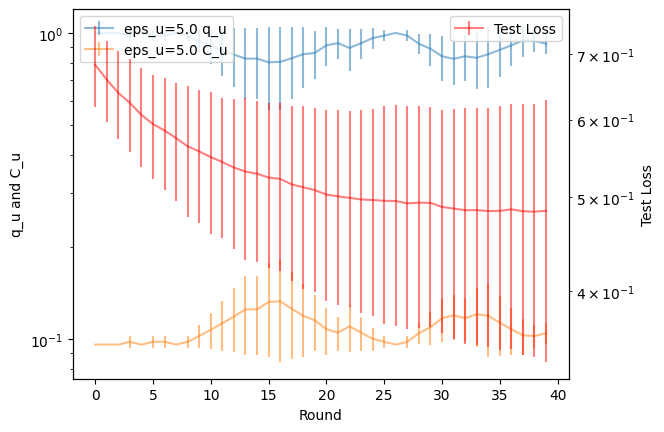

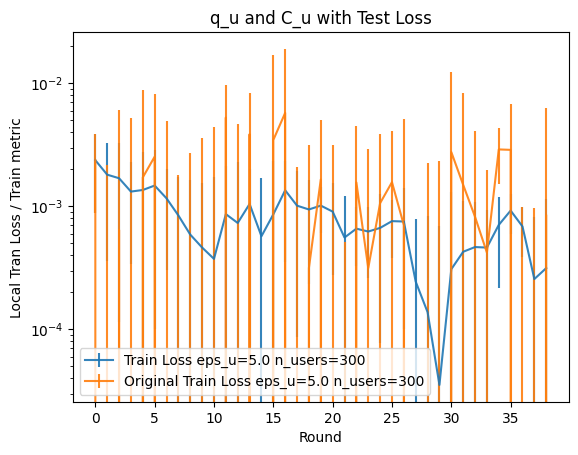

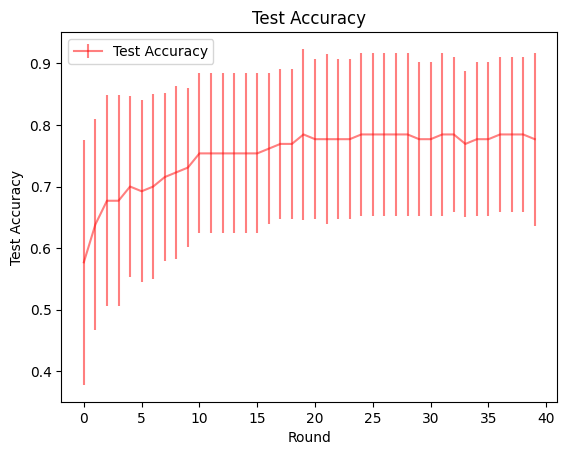

In [4]:
# heart disease with different delta
n_users_list = [300]
sigma = 1.0
epsilon_list = [5.0]
group_thresholds = [5.0]
ratio_list = [1.0]
delta = 1e-5
n_round = 40
dataset_name = 'heart_disease'
q_step_size = 0.9
times = 5
random_state = np.random.RandomState(0)
agg_strategy = "PULDP-AVG-online" # with Test Loss, assuming Test dataset
with_momentum = True
train_loss_dp = False

prefix_epsilon_u_list = []
for n_users in n_users_list:
    print("n_users:", n_users)
    epsilon_u = make_epsilon_u(n_users=n_users, dist="hetero", epsilon_list=epsilon_list, ratio_list=ratio_list, random_state=random_state)
    prefix_epsilon_u_list.append(list(epsilon_u.items())[:4])
    grouped = group_by_closest_below(epsilon_u_dct=epsilon_u, group_thresholds=group_thresholds)
    epsilon_u = {}
    for eps_u, user_ids in grouped.items():
        for user_id in user_ids:
            epsilon_u[user_id] = eps_u
    run_online_optimization(epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, group_thresholds, times, global_learning_rate=10.0, local_learning_rate=0.001, local_epochs=50, validation_ratio=0.9, agg_strategy=agg_strategy, with_momentum=with_momentum, train_loss_dp=train_loss_dp)
    show_online_optimization_result(epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, validation_ratio=0.9, agg_strategy=agg_strategy, with_momentum=with_momentum, train_loss_dp=train_loss_dp)

# show_online_optimization_result_from_n_users_list(prefix_epsilon_u_list, n_users_list, sigma, delta, n_round, dataset_name, q_step_size, validation_ratio=0.9, agg_strategy=agg_strategy, with_momentum=with_momentum, train_loss_dp=train_loss_dp)


#### Online optimization with Raw Train Loss
- share raw train loss without DP

n_users: 300
[16:29:08 INFO] Start federated learning simulation
[16:29:11 INFO] Original sampling_rate_q = 1.0, metric = 77.1956149061521
[16:29:11 INFO] Stepped sampling_rate_q = 0.9000000000000002, metric = 77.19037893811863
[16:29:11 INFO] eps_u = 8.0, diff = 8.57147280286857
[16:29:13 INFO] Original sampling_rate_q = 1.0, metric = 74.85615146160126
[16:29:13 INFO] Stepped sampling_rate_q = 0.9000000000000002, metric = 74.86505502462387
[16:29:13 INFO] eps_u = 8.0, diff = 8.32724301020302
[16:29:14 INFO] Original sampling_rate_q = 1.0, metric = 15.87671747803688
[16:29:14 INFO] Stepped sampling_rate_q = 0.9000000000000002, metric = 15.876817867159843
[16:29:14 INFO] eps_u = 8.0, diff = 1.7641912632518313
[16:29:15 INFO] Original sampling_rate_q = 1.0, metric = 33.7047532548507
[16:29:15 INFO] Stepped sampling_rate_q = 0.9000000000000002, metric = 33.70352017879486
[16:29:15 INFO] eps_u = 8.0, diff = 3.7436024993657995
[16:29:15 INFO] |----- Global test result of round 0
[16:29:15 I

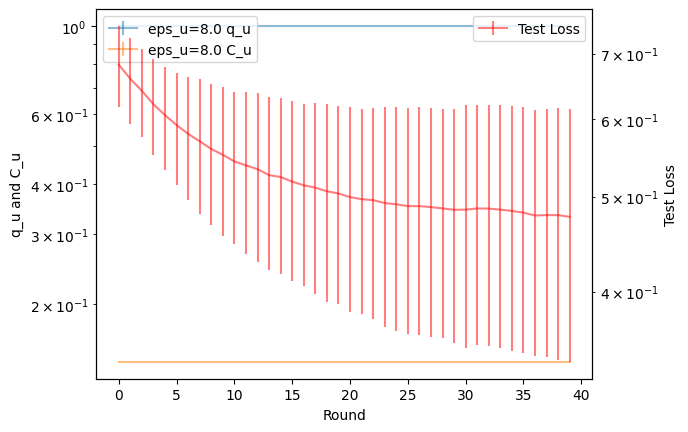

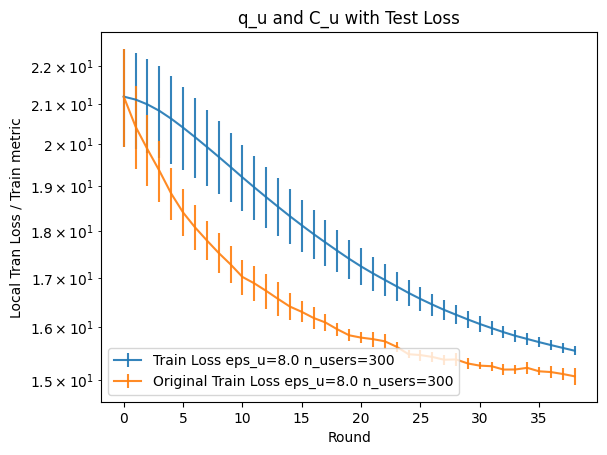

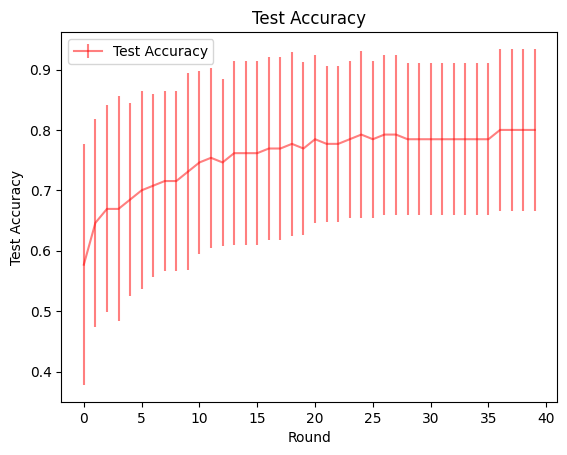

In [5]:
# heart disease with different delta
n_users_list = [300]
sigma = 1.0
epsilon_list = [8.0]
group_thresholds = [8.0]
ratio_list = [1.0]
delta = 1e-5
n_round = 40
dataset_name = 'heart_disease'
q_step_size = 0.9
times = 5
random_state = np.random.RandomState(0)
agg_strategy = "PULDP-AVG-online-TRAIN"
with_momentum = True
train_loss_dp = False

prefix_epsilon_u_list = []
for n_users in n_users_list:
    print("n_users:", n_users)
    epsilon_u = make_epsilon_u(n_users=n_users, dist="hetero", epsilon_list=epsilon_list, ratio_list=ratio_list, random_state=random_state)
    prefix_epsilon_u_list.append(list(epsilon_u.items())[:4])
    grouped = group_by_closest_below(epsilon_u_dct=epsilon_u, group_thresholds=group_thresholds)
    epsilon_u = {}
    for eps_u, user_ids in grouped.items():
        for user_id in user_ids:
            epsilon_u[user_id] = eps_u
    run_online_optimization(epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, group_thresholds, times, global_learning_rate=10.0, local_learning_rate=0.001, local_epochs=50, validation_ratio=0.9, agg_strategy=agg_strategy, with_momentum=with_momentum, train_loss_dp=train_loss_dp)
    show_online_optimization_result(epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, validation_ratio=0.9, agg_strategy=agg_strategy, with_momentum=with_momentum, train_loss_dp=train_loss_dp)

# show_online_optimization_result_from_n_users_list(prefix_epsilon_u_list, n_users_list, sigma, delta, n_round, dataset_name, q_step_size, validation_ratio=0.9, agg_strategy=agg_strategy, with_momentum=with_momentum, train_loss_dp=train_loss_dp)


#### Online optimization with user-level DP metric
- share approximated train loss with user-level DP metric

##### eps is shared

n_users: 300
[07:44:55 INFO] Start federated learning simulation
metric_list: ( 128 ) [1.0, 0.0, 0.5, 1.0, 1.0, 1.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 1.0, 0.3333333333333333, 0.0, 0.5, 0.0, 0.0, 0.5, 1.0, 1.0, 0.6666666666666666, 0.0, 0.0, 1.0, 0.0, 0.0, 0.3333333333333333, 0.0, 0.0, 0.5, 0.6666666666666666, 0.0, 0.5, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.5, 1.0, 0.5, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.5, 1.0, 0.5, 1.0, 1.0, 0.3333333333333333, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.5, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.5, 0.5, 0.0, 0.0, 0.3333333333333333, 0.0, 1.0, 1.0, 0.3333333333333333, 1.0, 1.0, 1.0, 0.3333333333333333, 1.0, 0.5, 1.0, 0.0, 0.3333333333333333, 1.0, 0.0, 0.0, 0.0, 0.25, 1.0, 0.5, 1.0, 0.0, 0.5, 0.6666666666666667, 1.0, 0.0, 0.0, 0.5, 0.0, 0.6666666666666666, 1.0, 0.3333333333333333, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.3333333333333333, 0.5, 1.0, 0.5, 0.5, 1.0, 0.0, 0.0, 0.0, 0.0, 0.5]
noise: 2.6050587633132514
[07:44:59 INFO] Original sampling_rate_q = 1.0, met

/Users/fumiyuki/.pyenv/versions/3.9.2/envs/acsilo/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/fumiyuki/.pyenv/versions/3.9.2/envs/acsilo/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


noise: 0.6653521837689685
[08:13:34 INFO] Stepped sampling_rate_q = 0.2621440000000001, metric = 2.538117156101106
[08:13:34 INFO] eps_u = 5.0, diff = 4.506953415378313
metric_list: ( 23 ) [0.0, 0.0, 0.42857142857142855, 0.0, 1.0, 0.6666666666666666, 0.0, 0.0, 0.5, 0.5, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.5, 0.0, 0.5, 1.0, 1.0, 0.0, 0.5]
noise: 0.5198178660536305
[08:13:36 INFO] Original sampling_rate_q = 0.32768, metric = 33.92045886624672
metric_list: ( 15 ) [0.3333333333333333, 0.42857142857142855, 0.0, 0.6666666666666666, 0.0, 0.19999999999999998, 0.0, 0.6666666666666666, 0.0, 0.5, 0.0, 1.0, 1.0, 1.0, 1.0]
noise: 0.9978593334372331
[08:13:38 INFO] Stepped sampling_rate_q = 0.2621440000000001, metric = 29.728307451916983
[08:13:38 INFO] eps_u = 5.0, diff = 4.192151414329736
[08:13:38 INFO] |----- Global test result of round 39
[08:13:38 INFO] 	 |----- Test/Acc: 0.8846153846153846 (26), Test/Loss: 0.4502742886543274
[08:13:38 INFO] |----- Global valid result of round 39
[08:13:38 INFO] 	

/Users/fumiyuki/.pyenv/versions/3.9.2/envs/acsilo/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/fumiyuki/.pyenv/versions/3.9.2/envs/acsilo/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


noise: 1.017114101124888
[10:08:50 INFO] Stepped sampling_rate_q = 0.20971520000000018, metric = 4.849977975487171
[10:08:50 INFO] eps_u = 5.0, diff = 7.231636373669575
metric_list: ( 14 ) [0.0, 1.0, 0.0, 0.5, 1.0, 0.5, 0.25, 1.0, 1.0, 0.5, 0.25, 0.3333333333333333, 1.0, 0.5]
noise: -1.6019659701896272
[10:08:51 INFO] Original sampling_rate_q = 0.2621440000000001, metric = 23.770780041289154
metric_list: ( 4 ) [1.0, 0.0, 1.0, 0.3333333333333333]
noise: -0.6386119604604149
[10:08:53 INFO] Stepped sampling_rate_q = 0.20971520000000018, metric = 8.081061233868205
[10:08:53 INFO] eps_u = 5.0, diff = 15.689718807420949
[10:08:53 INFO] |----- Global test result of round 6
[10:08:53 INFO] 	 |----- Test/Acc: 0.7692307692307693 (26), Test/Loss: 0.5481548309326172
[10:08:53 INFO] |----- Global valid result of round 6
[10:08:53 INFO] 	 |----- Test/Acc: 0.7543859649122807 (228), Test/Loss: 0.545808732509613
[10:08:55 INFO] eps_u: 5.0, original loss_diff: 23.044560305120605, (self.momentum[eps_u]: 

/Users/fumiyuki/.pyenv/versions/3.9.2/envs/acsilo/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/fumiyuki/.pyenv/versions/3.9.2/envs/acsilo/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


noise: 0.4026050354670262
[10:28:07 INFO] Stepped sampling_rate_q = 0.054975581388800036, metric = 7.323342933287239
[10:28:07 INFO] eps_u = 5.0, diff = 15.120982732394197
metric_list: ( 5 ) [0.25, 1.0, 0.5, 1.0, 0.0]
noise: -0.12974966793173365
[10:28:09 INFO] Original sampling_rate_q = 0.06871947673600003, metric = 38.12966070935749
metric_list: ( 0 ) []
noise: 0.07018640744114964
[10:28:10 INFO] Stepped sampling_rate_q = 0.054975581388800036, metric = 1.2766833140840315
[10:28:10 INFO] eps_u = 5.0, diff = 36.852977395273456
[10:28:10 INFO] |----- Global test result of round 18
[10:28:10 INFO] 	 |----- Test/Acc: 0.6153846153846154 (26), Test/Loss: 0.8119631409645081
[10:28:10 INFO] |----- Global valid result of round 18
[10:28:10 INFO] 	 |----- Test/Acc: 0.7587719298245614 (228), Test/Loss: 0.5002176761627197
[10:28:12 INFO] eps_u: 5.0, original loss_diff: 116.10726057654279, (self.momentum[eps_u]: 9.60516538098836)
[10:28:13 INFO] Next HP: (Q_u, C_u) = {5.0: (0.08589934592000005, 0.

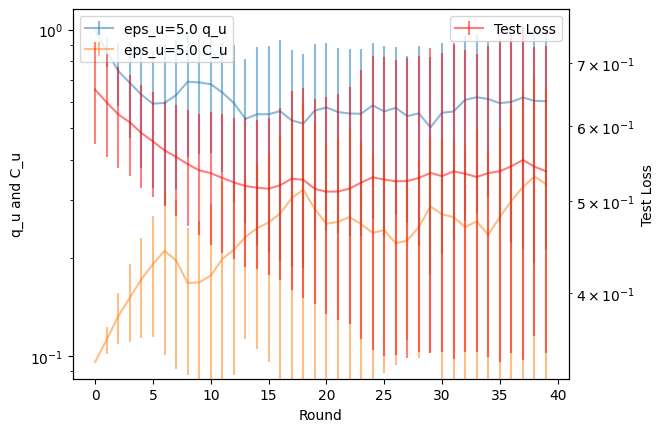

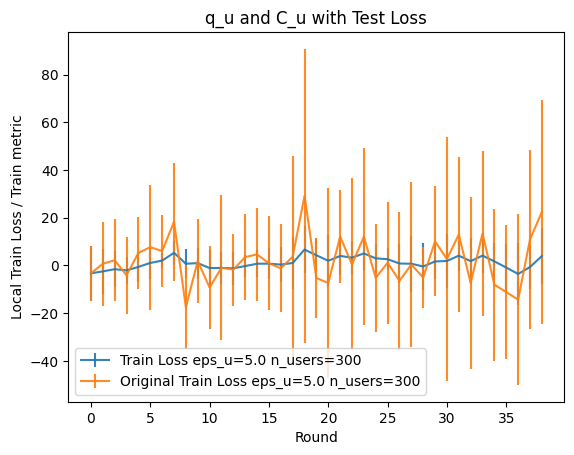

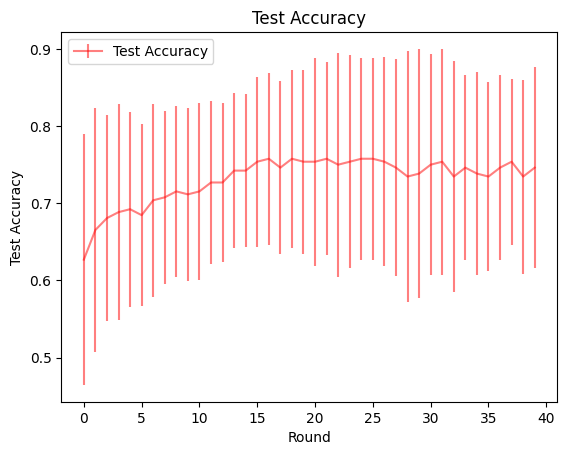

In [5]:
# heart disease with different delta
n_users_list = [300]
sigma = 1.0
epsilon_list = [5.0]
group_thresholds = [5.0]
ratio_list = [1.0]
delta = 1e-5
n_round = 40
dataset_name = 'heart_disease'
q_step_size = 0.8
times = 10
random_state = np.random.RandomState(0)
agg_strategy = "PULDP-AVG-online-TRAIN"
with_momentum = True
train_loss_dp = True
sigma_for_online_optimization = 5.0
total_dp_eps_for_online_optimization = True


prefix_epsilon_u_list = []
for n_users in n_users_list:
    print("n_users:", n_users)
    epsilon_u = make_epsilon_u(n_users=n_users, dist="hetero", epsilon_list=epsilon_list, ratio_list=ratio_list, random_state=random_state)
    prefix_epsilon_u_list.append(list(epsilon_u.items())[:4])
    grouped = group_by_closest_below(epsilon_u_dct=epsilon_u, group_thresholds=group_thresholds)
    epsilon_u = {}
    for eps_u, user_ids in grouped.items():
        for user_id in user_ids:
            epsilon_u[user_id] = eps_u
    run_online_optimization(
        epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, 
        group_thresholds, times, global_learning_rate=10.0, local_learning_rate=0.001, 
        local_epochs=50, validation_ratio=0.9, agg_strategy=agg_strategy, with_momentum=with_momentum, 
        train_loss_dp=train_loss_dp, sigma_for_online_optimization=sigma_for_online_optimization, 
        total_dp_eps_for_online_optimization=total_dp_eps_for_online_optimization)
    show_online_optimization_result(
        epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, 
        validation_ratio=0.9, agg_strategy=agg_strategy, with_momentum=with_momentum, 
        train_loss_dp=train_loss_dp, sigma_for_online_optimization=sigma_for_online_optimization, 
        total_dp_eps_for_online_optimization=total_dp_eps_for_online_optimization)

# show_online_optimization_result_from_n_users_list(prefix_epsilon_u_list, n_users_list, sigma, delta, n_round, dataset_name, q_step_size, validation_ratio=0.9, agg_strategy=agg_strategy, with_momentum=with_momentum, train_loss_dp=train_loss_dp)


##### eps is not shared

n_users: 300
[23:52:58 INFO] Start federated learning simulation
metric_list: ( 128 ) [1.0, 0.0, 0.5, 1.0, 1.0, 1.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 1.0, 0.3333333333333333, 0.0, 0.5, 0.0, 0.0, 0.5, 1.0, 1.0, 0.6666666666666666, 0.0, 0.0, 1.0, 0.0, 0.0, 0.3333333333333333, 0.0, 0.0, 0.5, 0.6666666666666666, 0.0, 0.5, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.5, 1.0, 0.5, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.5, 1.0, 0.5, 1.0, 1.0, 0.3333333333333333, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.5, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.5, 0.5, 0.0, 0.0, 0.3333333333333333, 0.0, 1.0, 1.0, 0.3333333333333333, 1.0, 1.0, 1.0, 0.3333333333333333, 1.0, 0.5, 1.0, 0.0, 0.3333333333333333, 1.0, 0.0, 0.0, 0.0, 0.25, 1.0, 0.5, 1.0, 0.0, 0.5, 0.6666666666666667, 1.0, 0.0, 0.0, 0.5, 0.0, 0.6666666666666666, 1.0, 0.3333333333333333, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.3333333333333333, 0.5, 1.0, 0.5, 0.5, 1.0, 0.0, 0.0, 0.0, 0.0, 0.5]
noise: 2.6050587633132514
[23:53:02 INFO] Original sampling_rate_q = 1.0, met

/Users/fumiyuki/.pyenv/versions/3.9.2/envs/acsilo/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/fumiyuki/.pyenv/versions/3.9.2/envs/acsilo/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


noise: 0.6653521837689685
[00:21:32 INFO] Stepped sampling_rate_q = 0.2621440000000001, metric = 2.538117156101106
[00:21:32 INFO] eps_u = 5.0, diff = 4.506953415378313
metric_list: ( 23 ) [0.0, 0.0, 0.42857142857142855, 0.0, 1.0, 0.6666666666666666, 0.0, 0.0, 0.5, 0.5, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.5, 0.0, 0.5, 1.0, 1.0, 0.0, 0.5]
noise: 0.5198178660536305
[00:21:34 INFO] Original sampling_rate_q = 0.32768, metric = 33.92045886624672
metric_list: ( 15 ) [0.3333333333333333, 0.42857142857142855, 0.0, 0.6666666666666666, 0.0, 0.19999999999999998, 0.0, 0.6666666666666666, 0.0, 0.5, 0.0, 1.0, 1.0, 1.0, 1.0]
noise: 0.9978593334372331
[00:21:36 INFO] Stepped sampling_rate_q = 0.2621440000000001, metric = 29.728307451916983
[00:21:36 INFO] eps_u = 5.0, diff = 4.192151414329736
[00:21:36 INFO] |----- Global test result of round 39
[00:21:36 INFO] 	 |----- Test/Acc: 0.8846153846153846 (26), Test/Loss: 0.4502742886543274
[00:21:36 INFO] |----- Global valid result of round 39
[00:21:36 INFO] 	

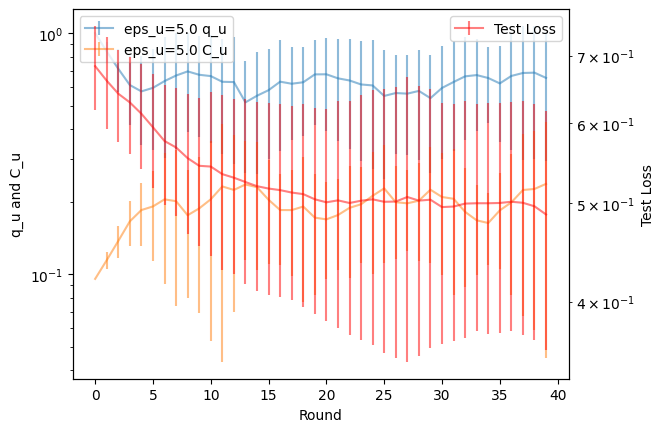

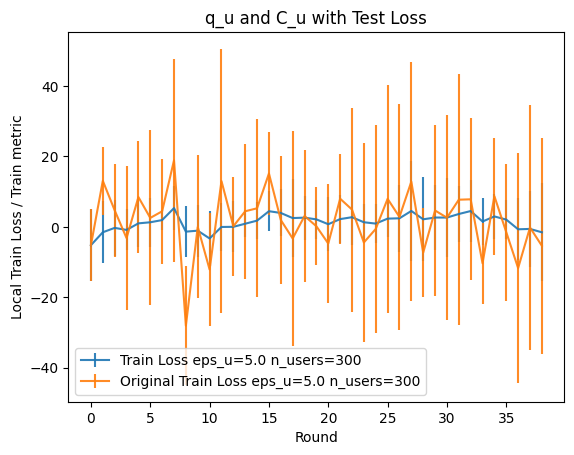

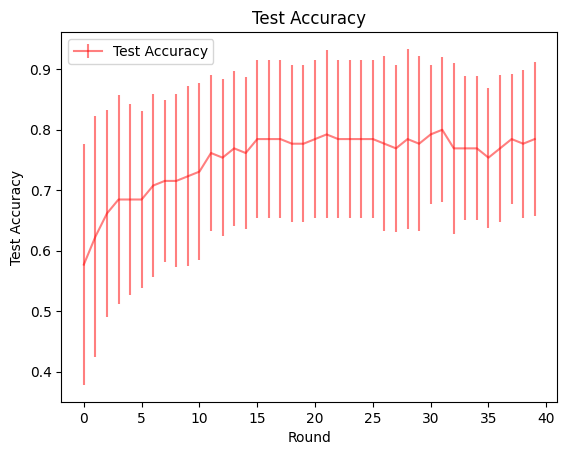

In [4]:
# heart disease with different delta
n_users_list = [300]
sigma = 1.0
epsilon_list = [5.0]
group_thresholds = [5.0]
ratio_list = [1.0]
delta = 1e-5
n_round = 40
dataset_name = 'heart_disease'
q_step_size = 0.8
times = 10
random_state = np.random.RandomState(0)
agg_strategy = "PULDP-AVG-online-TRAIN"
with_momentum = True
train_loss_dp = True
sigma_for_online_optimization = 5.0
total_dp_eps_for_online_optimization = False


prefix_epsilon_u_list = []
for n_users in n_users_list:
    print("n_users:", n_users)
    epsilon_u = make_epsilon_u(n_users=n_users, dist="hetero", epsilon_list=epsilon_list, ratio_list=ratio_list, random_state=random_state)
    prefix_epsilon_u_list.append(list(epsilon_u.items())[:4])
    grouped = group_by_closest_below(epsilon_u_dct=epsilon_u, group_thresholds=group_thresholds)
    epsilon_u = {}
    for eps_u, user_ids in grouped.items():
        for user_id in user_ids:
            epsilon_u[user_id] = eps_u
    run_online_optimization(
        epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, 
        group_thresholds, times, global_learning_rate=10.0, local_learning_rate=0.001, 
        local_epochs=50, validation_ratio=0.9, agg_strategy=agg_strategy, with_momentum=with_momentum, 
        train_loss_dp=train_loss_dp, sigma_for_online_optimization=sigma_for_online_optimization, 
        total_dp_eps_for_online_optimization=total_dp_eps_for_online_optimization)
    show_online_optimization_result(
        epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, 
        validation_ratio=0.9, agg_strategy=agg_strategy, with_momentum=with_momentum, 
        train_loss_dp=train_loss_dp, sigma_for_online_optimization=sigma_for_online_optimization, 
        total_dp_eps_for_online_optimization=total_dp_eps_for_online_optimization)

# show_online_optimization_result_from_n_users_list(prefix_epsilon_u_list, n_users_list, sigma, delta, n_round, dataset_name, q_step_size, validation_ratio=0.9, agg_strategy=agg_strategy, with_momentum=with_momentum, train_loss_dp=train_loss_dp)


## Multiple Epsilon groups

#### with DP train metric

In [6]:
# heart disease with different delta
n_users_list = [300]
sigma = 1.0
epsilon_list = [1.0, 5.0, 10.0]
group_thresholds = epsilon_list
ratio_list = [0.3, 0.4, 0.3]
delta = 1e-5
n_round = 40
dataset_name = 'heart_disease'
q_step_size = 0.8
times = 10
random_state = np.random.RandomState(0)
agg_strategy = "PULDP-AVG-online-TRAIN"
with_momentum = True
train_loss_dp = True
sigma_for_online_optimization = None
total_dp_eps_for_online_optimization = True


prefix_epsilon_u_list = []
for n_users in n_users_list:
    print("n_users:", n_users)
    epsilon_u = make_epsilon_u(n_users=n_users, dist="hetero", epsilon_list=epsilon_list, ratio_list=ratio_list, random_state=random_state)
    prefix_epsilon_u_list.append(list(epsilon_u.items())[:4])
    grouped = group_by_closest_below(epsilon_u_dct=epsilon_u, group_thresholds=group_thresholds)
    epsilon_u = {}
    for eps_u, user_ids in grouped.items():
        for user_id in user_ids:
            epsilon_u[user_id] = eps_u
    run_online_optimization(
        epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, 
        group_thresholds, times, global_learning_rate=10.0, local_learning_rate=0.001, 
        local_epochs=50, validation_ratio=0.9, agg_strategy=agg_strategy, with_momentum=with_momentum, 
        train_loss_dp=train_loss_dp, sigma_for_online_optimization=sigma_for_online_optimization, 
        total_dp_eps_for_online_optimization=total_dp_eps_for_online_optimization)
    show_online_optimization_result(
        epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, 
        validation_ratio=0.9, agg_strategy=agg_strategy, with_momentum=with_momentum, 
        train_loss_dp=train_loss_dp, sigma_for_online_optimization=sigma_for_online_optimization, 
        total_dp_eps_for_online_optimization=total_dp_eps_for_online_optimization)

# show_online_optimization_result_from_n_users_list(prefix_epsilon_u_list, n_users_list, sigma, delta, n_round, dataset_name, q_step_size, validation_ratio=0.9, agg_strategy=agg_strategy, with_momentum=with_momentum, train_loss_dp=train_loss_dp)


n_users: 300
[11:01:01 INFO] Start federated learning simulation
metric_list: ( 40 ) [0.0, 1.0, 0.0, 0.0, 0.5, 0.0, 0.5, 0.0, 0.0, 0.3333333333333333, 0.5, 0.0, 0.5, 0.5, 0.0, 0.5, 0.5, 1.0, 0.3333333333333333, 0.0, 0.0, 0.5, 0.5, 0.0, 1.0, 1.0, 0.3333333333333333, 1.0, 0.5, 1.0, 0.5, 0.0, 0.0, 0.0, 0.0, 1.0, 0.5, 0.0, 0.0, 0.5]
noise: 11.062383291233829
[11:01:05 INFO] Original sampling_rate_q = 1.0, metric = 25.56238329123383
metric_list: ( 34 ) [0.0, 1.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.3333333333333333, 0.5, 0.5, 0.5, 0.0, 0.5, 0.5, 1.0, 0.3333333333333333, 0.0, 0.5, 0.0, 1.0, 1.0, 0.3333333333333333, 1.0, 0.5, 1.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0]
noise: -14.784066962158816
[11:01:05 INFO] Stepped sampling_rate_q = 0.7999999999999997, metric = -3.480083702698521
[11:01:05 INFO] eps_u = 1.0, diff = 29.04246699393235
metric_list: ( 32 ) [0.5, 1.0, 0.5, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.3333333333333333, 1.0, 0.3333333333333

/Users/fumiyuki/.pyenv/versions/3.9.2/envs/acsilo/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/fumiyuki/.pyenv/versions/3.9.2/envs/acsilo/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


noise: -0.2760998447580902
[11:05:50 INFO] Stepped sampling_rate_q = 0.5120000000000002, metric = -0.5392575092931446
[11:05:50 INFO] eps_u = 10.0, diff = 5.056334372379892
metric_list: ( 13 ) [0.0, 0.3333333333333333, 1.0, 1.0, 0.0, 0.5, 0.0, 0.0, 1.0, 0.0, 0.0, 0.5, 0.5]
noise: -8.705173465026611
[11:05:50 INFO] Original sampling_rate_q = 1.0, metric = -3.8718401316932773
metric_list: ( 10 ) [0.0, 0.3333333333333333, 1.0, 0.0, 0.5, 0.0, 0.0, 1.0, 0.0, 0.5]
noise: 0.1303800012515172
[11:05:50 INFO] Stepped sampling_rate_q = 0.8, metric = 4.329641668231063
[11:05:50 INFO] eps_u = 5.0, diff = -8.201481799924341
metric_list: ( 10 ) [0.3333333333333333, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.5, 1.0, 0.5]
noise: 22.64263217863422
[11:05:51 INFO] Original sampling_rate_q = 0.6400000000000002, metric = 43.712446112449285
metric_list: ( 6 ) [0.25, 0.0, 0.0, 0.0, 1.0, 1.0]
noise: -6.843526879254552
[11:05:57 INFO] Stepped sampling_rate_q = 0.5120000000000002, metric = -8.971732186044042
[11:05:57 INF

/Users/fumiyuki/.pyenv/versions/3.9.2/envs/acsilo/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/fumiyuki/.pyenv/versions/3.9.2/envs/acsilo/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


noise: -0.9026058769899725
[11:46:28 INFO] Original sampling_rate_q = 0.40959999999999996, metric = -2.2036276293700503
metric_list: ( 2 ) [0.0, 0.5]
noise: -18.095741226727203
[11:46:28 INFO] Stepped sampling_rate_q = 0.32768000000000014, metric = -53.69794075539305
[11:46:28 INFO] eps_u = 1.0, diff = 51.494313126023
metric_list: ( 3 ) [0.0, 0.0, 0.5]
noise: -1.1295693268221343
[11:46:32 INFO] Original sampling_rate_q = 0.40959999999999996, metric = -1.5370344893118515
metric_list: ( 0 ) []
noise: 1.2780456799752917
[11:46:35 INFO] Stepped sampling_rate_q = 0.32768000000000014, metric = 3.9002858885964695
[11:46:35 INFO] eps_u = 10.0, diff = -5.437320377908321
metric_list: ( 5 ) [1.0, 0.5, 0.25, 0.0, 0.0]
noise: -8.116242741210868
[11:46:35 INFO] Original sampling_rate_q = 0.8000000000000003, metric = -7.957803426513583
metric_list: ( 3 ) [0.5, 0.25, 0.0]
noise: -1.6085869334277907
[11:46:36 INFO] Stepped sampling_rate_q = 0.6400000000000003, metric = -1.3415420834809222
[11:46:36 INF

/Users/fumiyuki/.pyenv/versions/3.9.2/envs/acsilo/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/fumiyuki/.pyenv/versions/3.9.2/envs/acsilo/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


noise: -3.532002571034145
[12:18:16 INFO] Stepped sampling_rate_q = 0.26214400000000004, metric = -13.473520549904421
[12:18:16 INFO] eps_u = 1.0, diff = 19.779871130560398
metric_list: ( 2 ) [0.25, 1.0]
noise: -1.7584199732982075
[12:18:21 INFO] Original sampling_rate_q = 0.5120000000000002, metric = -0.9930077603480612
metric_list: ( 3 ) [0.25, 0.5, 1.0]
noise: 1.8825847666820976
[12:18:25 INFO] Stepped sampling_rate_q = 0.40959999999999996, metric = 8.868615153032467
[12:18:25 INFO] eps_u = 10.0, diff = -9.861622913380527
metric_list: ( 9 ) [1.0, 1.0, 0.0, 0.0, 0.0, 0.3333333333333333, 0.0, 0.3333333333333333, 0.0]
noise: 7.350863901623873
[12:18:25 INFO] Original sampling_rate_q = 1.0, metric = 10.017530568290539
metric_list: ( 7 ) [1.0, 1.0, 0.0, 0.0, 0.0, 0.3333333333333333, 0.0]
noise: 8.972243706939617
[12:18:25 INFO] Stepped sampling_rate_q = 0.8, metric = 14.131971300341188
[12:18:25 INFO] eps_u = 5.0, diff = -4.1144407320506495
metric_list: ( 2 ) [0.25, 0.5]
noise: 12.110648

/Users/fumiyuki/.pyenv/versions/3.9.2/envs/acsilo/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/fumiyuki/.pyenv/versions/3.9.2/envs/acsilo/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


metric_list: ( 0 ) []
noise: 3.0848422049572664
[12:54:18 INFO] Stepped sampling_rate_q = 0.16777216000000014, metric = 18.387092381461045
[12:54:18 INFO] eps_u = 1.0, diff = -6.970243322294126
metric_list: ( 5 ) [0.0, 1.0, 0.25, 0.6666666666666666, 0.0]
noise: 2.4797430110148753
[12:54:18 INFO] Original sampling_rate_q = 1.0, metric = 4.396409677681541
metric_list: ( 4 ) [0.0, 0.25, 0.6666666666666666, 0.0]
noise: -3.704148781331416
[12:54:18 INFO] Stepped sampling_rate_q = 0.7999999999999998, metric = -3.4843526433309377
[12:54:18 INFO] eps_u = 10.0, diff = 7.8807623210124795
metric_list: ( 10 ) [0.5, 0.5, 0.2, 1.0, 1.0, 1.0, 0.0, 0.5, 0.0, 0.0]
noise: -1.2947999305944033
[12:54:18 INFO] Original sampling_rate_q = 0.8, metric = 4.256500086756995
metric_list: ( 5 ) [1.0, 1.0, 0.5, 1.0, 0.0]
noise: -1.7637714894790195
[12:54:19 INFO] Stepped sampling_rate_q = 0.6400000000000003, metric = 2.7128570476890306
[12:54:19 INFO] eps_u = 5.0, diff = 1.5436430390679647
metric_list: ( 3 ) [1.0, 

/Users/fumiyuki/.pyenv/versions/3.9.2/envs/acsilo/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/fumiyuki/.pyenv/versions/3.9.2/envs/acsilo/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


noise: -0.5052680615102224
[13:23:26 INFO] Stepped sampling_rate_q = 0.20971520000000018, metric = -2.40930586581336
[13:23:26 INFO] eps_u = 5.0, diff = 19.625821700933813
metric_list: ( 20 ) [1.0, 0.3333333333333333, 1.0, 0.0, 0.0, 0.5, 0.5, 0.5, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.3333333333333333, 1.0, 0.0, 1.0, 0.0, 0.5]
noise: -3.3715328484750056
[13:23:27 INFO] Original sampling_rate_q = 1.0, metric = 7.29513381819166
metric_list: ( 18 ) [1.0, 0.3333333333333333, 1.0, 0.0, 0.0, 0.5, 0.5, 0.5, 1.0, 1.0, 1.0, 0.0, 1.0, 0.3333333333333333, 0.0, 1.0, 0.0, 0.5]
noise: -16.04339708004652
[13:23:27 INFO] Stepped sampling_rate_q = 0.7999999999999997, metric = -7.970913016724822
[13:23:27 INFO] eps_u = 1.0, diff = 15.266046834916482
metric_list: ( 15 ) [0.0, 1.0, 0.25, 0.5, 1.0, 0.0, 0.0, 0.0, 0.5, 0.0, 1.0, 1.0, 0.0, 1.0, 0.5]
noise: 2.085894523526137
[13:23:27 INFO] Original sampling_rate_q = 1.0, metric = 8.835894523526136
metric_list: ( 14 ) [0.0, 1.0, 0.25, 0.5, 1.0, 0.0, 0.0, 0.0, 0.5, 

/Users/fumiyuki/.pyenv/versions/3.9.2/envs/acsilo/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/fumiyuki/.pyenv/versions/3.9.2/envs/acsilo/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


noise: 1.2048904545603774
[13:52:28 INFO] Stepped sampling_rate_q = 0.2621440000000001, metric = 4.596292322389133
[13:52:28 INFO] eps_u = 5.0, diff = -3.1975169243739447
metric_list: ( 18 ) [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.0, 0.5, 1.0, 0.5, 0.5, 0.3333333333333333, 0.5, 0.0, 1.0, 0.0, 0.0]
noise: -44.43764350584238
[13:52:29 INFO] Original sampling_rate_q = 1.0, metric = -33.604310172509045
metric_list: ( 14 ) [1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.0, 0.5, 0.5, 0.3333333333333333, 0.5, 1.0, 0.0, 0.0]
noise: 48.43508065927692
[13:52:29 INFO] Stepped sampling_rate_q = 0.7999999999999997, metric = 70.96051749076284
[13:52:29 INFO] eps_u = 1.0, diff = -104.56482766327188
metric_list: ( 14 ) [1.0, 1.0, 0.5, 1.0, 0.6666666666666666, 0.0, 0.5, 0.3333333333333333, 0.3333333333333333, 0.5, 0.0, 1.0, 1.0, 1.0]
noise: 5.191006860809314
[13:52:29 INFO] Original sampling_rate_q = 1.0, metric = 14.024340194142646
metric_list: ( 13 ) [1.0, 1.0, 0.5, 1.0, 0.0, 0.5, 0.3333333333333333, 0.33333333333333

/Users/fumiyuki/.pyenv/versions/3.9.2/envs/acsilo/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/fumiyuki/.pyenv/versions/3.9.2/envs/acsilo/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


noise: -1.1444068909207394
[14:16:29 INFO] Stepped sampling_rate_q = 0.40960000000000013, metric = -2.7939621360369604
[14:16:29 INFO] eps_u = 5.0, diff = 13.152842832840827
metric_list: ( 9 ) [0.5, 1.0, 1.0, 0.0, 0.5, 0.6666666666666666, 0.0, 0.3333333333333333, 1.0]
noise: 32.071067478608704
[14:16:36 INFO] Original sampling_rate_q = 0.5120000000000002, metric = 72.4044286691576
metric_list: ( 8 ) [0.5, 1.0, 0.5, 0.6666666666666666, 0.0, 0.6666666666666666, 0.0, 0.3333333333333333]
noise: 2.492185450666374
[14:16:36 INFO] Stepped sampling_rate_q = 0.40959999999999996, metric = 15.03626005208262
[14:16:36 INFO] eps_u = 1.0, diff = 57.36816861707498
metric_list: ( 16 ) [0.5, 1.0, 1.0, 0.0, 1.0, 0.3333333333333333, 0.3333333333333333, 0.6666666666666666, 0.0, 0.0, 0.5, 0.0, 1.0, 0.6666666666666666, 0.5, 0.5]
noise: 1.2068567311585008
[14:16:36 INFO] Original sampling_rate_q = 1.0, metric = 9.206856731158501
metric_list: ( 12 ) [1.0, 1.0, 0.0, 1.0, 0.6666666666666666, 0.0, 0.0, 0.5, 0.0,

/Users/fumiyuki/.pyenv/versions/3.9.2/envs/acsilo/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/fumiyuki/.pyenv/versions/3.9.2/envs/acsilo/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


metric_list: ( 0 ) []
noise: -2.9047028699247868
[15:08:02 INFO] Original sampling_rate_q = 0.26214400000000004, metric = -11.080562095355173
metric_list: ( 3 ) [0.0, 0.5, 0.5]
noise: -6.712171008046507
[15:08:02 INFO] Stepped sampling_rate_q = 0.20971520000000027, metric = -27.237753906471728
[15:08:02 INFO] eps_u = 1.0, diff = 16.157191811116554
metric_list: ( 5 ) [1.0, 0.5, 0.5, 1.0, 0.3333333333333333]
noise: 1.6195570920005644
[15:08:02 INFO] Original sampling_rate_q = 1.0, metric = 4.952890425333898
metric_list: ( 5 ) [1.0, 0.5, 0.5, 1.0, 0.3333333333333333]
noise: -1.3374452234300926
[15:08:02 INFO] Stepped sampling_rate_q = 0.7999999999999998, metric = 2.4948601373790518
[15:08:02 INFO] eps_u = 10.0, diff = 2.458030287954846
metric_list: ( 7 ) [1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0]
noise: 1.2325767557033165
[15:08:03 INFO] Original sampling_rate_q = 0.6400000000000003, metric = 6.613401180786429
metric_list: ( 4 ) [0.0, 0.0, 0.5, 0.5]
noise: 6.7203804733287145
[15:08:09 INFO] Step

/Users/fumiyuki/.pyenv/versions/3.9.2/envs/acsilo/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/fumiyuki/.pyenv/versions/3.9.2/envs/acsilo/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


noise: -11.806769422396979
[15:28:48 INFO] Stepped sampling_rate_q = 0.40959999999999996, metric = -28.825120660148876
[15:28:48 INFO] eps_u = 1.0, diff = 50.088880515229754
metric_list: ( 9 ) [0.0, 0.3333333333333333, 1.0, 0.0, 1.0, 0.6666666666666666, 0.0, 1.0, 1.0]
noise: -2.7007119902311176
[15:28:48 INFO] Original sampling_rate_q = 0.7999999999999998, metric = 2.8741100122111036
metric_list: ( 6 ) [0.3333333333333333, 1.0, 0.0, 1.0, 0.0, 1.0]
noise: -2.0038779579806336
[15:28:50 INFO] Stepped sampling_rate_q = 0.6400000000000002, metric = 2.077274023988592
[15:28:50 INFO] eps_u = 10.0, diff = 0.7968359882225116
metric_list: ( 4 ) [0.5, 0.0, 0.25, 0.0]
noise: -0.3163522274811344
[15:28:56 INFO] Original sampling_rate_q = 0.5120000000000002, metric = 0.846968305700909
metric_list: ( 5 ) [0.5, 0.0, 0.25, 0.0, 0.0]
noise: -0.7203175881759531
[15:28:59 INFO] Stepped sampling_rate_q = 0.40960000000000013, metric = 0.07246682574230186
[15:28:59 INFO] eps_u = 5.0, diff = 0.774501479958607

/Users/fumiyuki/.pyenv/versions/3.9.2/envs/acsilo/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/fumiyuki/.pyenv/versions/3.9.2/envs/acsilo/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


metric_list: ( 0 ) []
noise: -0.4587087003958469
[15:58:55 INFO] Original sampling_rate_q = 0.20971520000000027, metric = -2.18729353139804
metric_list: ( 1 ) [0.0]
noise: 2.1110450268513286
[15:58:55 INFO] Stepped sampling_rate_q = 0.16777216000000014, metric = 12.58280889303283
[15:58:55 INFO] eps_u = 1.0, diff = -14.77010242443087
metric_list: ( 2 ) [0.0, 1.0]
noise: 0.9029270009609
[15:58:59 INFO] Original sampling_rate_q = 0.32768000000000014, metric = 5.807272341799619
metric_list: ( 2 ) [1.0, 0.0]
noise: -1.2120548751160325
[15:59:01 INFO] Stepped sampling_rate_q = 0.26214400000000004, metric = -0.8089251522675799
[15:59:01 INFO] eps_u = 10.0, diff = 6.616197494067199
metric_list: ( 10 ) [0.0, 0.0, 0.0, 0.25, 0.5, 1.0, 0.0, 0.0, 1.0, 0.0]
noise: 6.3886974764451425
[15:59:01 INFO] Original sampling_rate_q = 1.0, metric = 9.138697476445142
metric_list: ( 9 ) [0.0, 0.0, 0.25, 0.5, 1.0, 0.0, 0.0, 1.0, 0.0]
noise: 0.9577132500438087
[15:59:02 INFO] Stepped sampling_rate_q = 0.8, metr

#### online optimization with Test loss

n_users: 300
[08:08:13 INFO] Start federated learning simulation
[08:08:21 INFO] |----- Global test result of round 0
[08:08:21 INFO] 	 |----- Test/Acc: 0.38461538461538464 (26), Test/Loss: 0.7309087514877319
[08:08:22 INFO] |----- Global valid result of round 0
[08:08:22 INFO] 	 |----- Test/Acc: 0.6578947368421053 (228), Test/Loss: 0.6637920141220093
[08:08:22 INFO] eps_u = 1.0, diff = -0.0008851885795593262
[08:08:22 INFO] eps_u = 10.0, diff = 0.016720473766326904
[08:08:22 INFO] eps_u = 5.0, diff = 0.032002031803131104
[08:08:22 INFO] eps_u: 1.0, original loss_diff: -0.0008851885795593262, (self.momentum[eps_u]: -0.0008851885795593262)
[08:08:22 INFO] eps_u: 10.0, original loss_diff: 0.016720473766326904, (self.momentum[eps_u]: 0.016720473766326904)
[08:08:22 INFO] eps_u: 5.0, original loss_diff: 0.032002031803131104, (self.momentum[eps_u]: 0.032002031803131104)
[08:08:22 INFO] Next HP: (Q_u, C_u) = {1.0: (0.95, 0.041114166378974915), 10.0: (1.0, 0.29855435714125633), 5.0: (1.0, 0.1

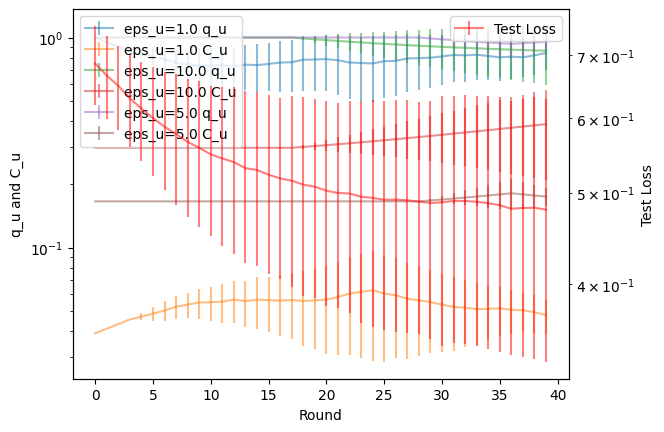

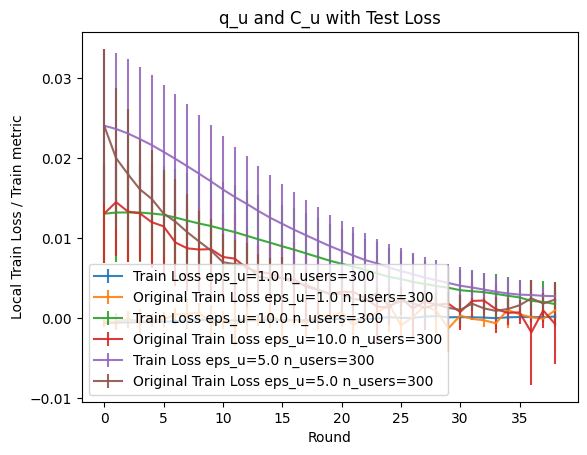

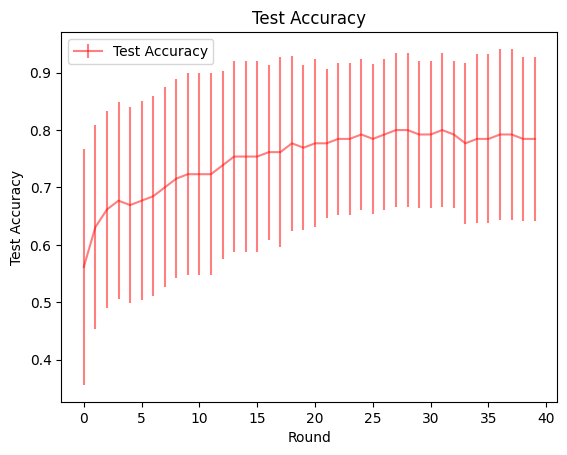

In [11]:
# heart disease with different delta
n_users_list = [300]
sigma = 1.0
epsilon_list = [1.0, 5.0, 10.0]
group_thresholds = epsilon_list
ratio_list = [0.3, 0.4, 0.3]
delta = 1e-5
n_round = 40
dataset_name = 'heart_disease'
q_step_size = 0.95
times = 5
random_state = np.random.RandomState(0)
agg_strategy = "PULDP-AVG-online"
with_momentum = True
train_loss_dp = False

prefix_epsilon_u_list = []
for n_users in n_users_list:
    print("n_users:", n_users)
    epsilon_u = make_epsilon_u(n_users=n_users, dist="hetero", epsilon_list=epsilon_list, ratio_list=ratio_list, random_state=random_state)
    prefix_epsilon_u_list.append(list(epsilon_u.items())[:4])
    grouped = group_by_closest_below(epsilon_u_dct=epsilon_u, group_thresholds=group_thresholds)
    epsilon_u = {}
    for eps_u, user_ids in grouped.items():
        for user_id in user_ids:
            epsilon_u[user_id] = eps_u
    run_online_optimization(epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, group_thresholds, times, global_learning_rate=10.0, local_learning_rate=0.001, local_epochs=50, validation_ratio=0.9, agg_strategy=agg_strategy, with_momentum=with_momentum, train_loss_dp=train_loss_dp)
    show_online_optimization_result(epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, validation_ratio=0.9, agg_strategy=agg_strategy, with_momentum=with_momentum, train_loss_dp=train_loss_dp)

# show_online_optimization_result_from_n_users_list(prefix_epsilon_u_list, n_users_list, sigma, delta, n_round, dataset_name, q_step_size, validation_ratio=0.9, agg_strategy=agg_strategy, with_momentum=with_momentum, train_loss_dp=train_loss_dp)


#### online optimization with non-DP train-loss


n_users: 300
[08:39:29 INFO] Start federated learning simulation
[08:39:32 INFO] Original sampling_rate_q = 1.0, metric = 77.28462961614132
[08:39:32 INFO] Stepped sampling_rate_q = 0.9500000000000001, metric = 77.27402478357155
[08:39:32 INFO] eps_u = 1.0, diff = -0.010604832569768519
[08:39:32 INFO] Original sampling_rate_q = 1.0, metric = 77.23117638130981
[08:39:32 INFO] Stepped sampling_rate_q = 0.9500000000000002, metric = 77.22843175133069
[08:39:32 INFO] eps_u = 10.0, diff = -0.002744629979119395
[08:39:32 INFO] Original sampling_rate_q = 1.0, metric = 77.22694032887618
[08:39:32 INFO] Stepped sampling_rate_q = 0.9499999999999997, metric = 77.2109629591306
[08:39:32 INFO] eps_u = 5.0, diff = -0.015977369745584724
[08:39:35 INFO] Original sampling_rate_q = 1.0, metric = 74.9636406203111
[08:39:35 INFO] Stepped sampling_rate_q = 0.9500000000000001, metric = 74.95716726283233
[08:39:35 INFO] eps_u = 1.0, diff = -0.006473357478768094
[08:39:35 INFO] Original sampling_rate_q = 1.0, 

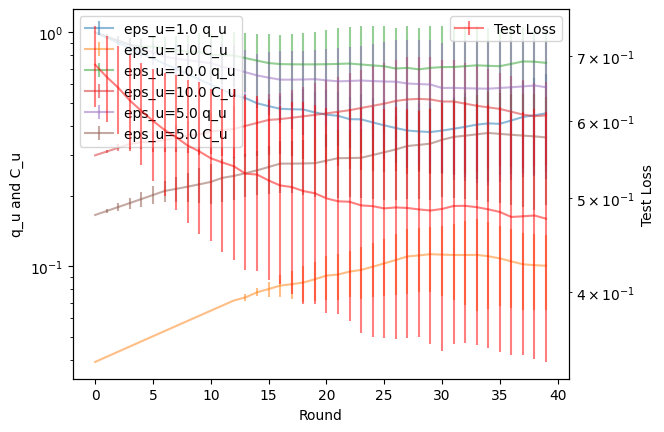

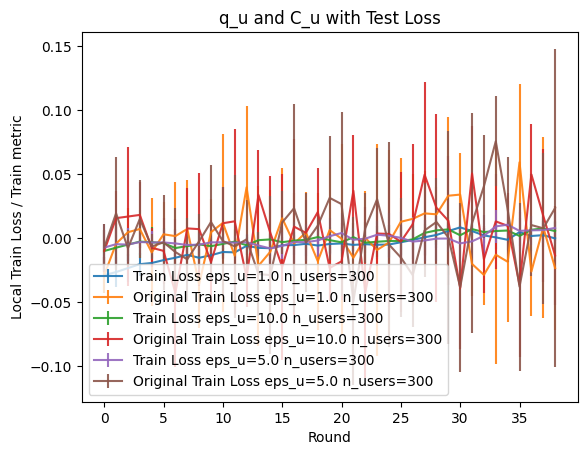

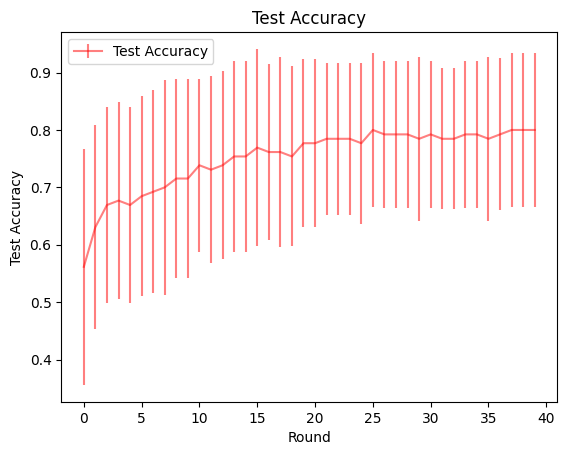

In [3]:
# heart disease with different delta
n_users_list = [300]
sigma = 1.0
epsilon_list = [1.0, 5.0, 10.0]
group_thresholds = epsilon_list
ratio_list = [0.3, 0.4, 0.3]
delta = 1e-5
n_round = 40
dataset_name = 'heart_disease'
q_step_size = 0.95
times = 5
random_state = np.random.RandomState(0)
agg_strategy = "PULDP-AVG-online-TRAIN"
with_momentum = True
train_loss_dp = False

prefix_epsilon_u_list = []
for n_users in n_users_list:
    print("n_users:", n_users)
    epsilon_u = make_epsilon_u(n_users=n_users, dist="hetero", epsilon_list=epsilon_list, ratio_list=ratio_list, random_state=random_state)
    prefix_epsilon_u_list.append(list(epsilon_u.items())[:4])
    grouped = group_by_closest_below(epsilon_u_dct=epsilon_u, group_thresholds=group_thresholds)
    epsilon_u = {}
    for eps_u, user_ids in grouped.items():
        for user_id in user_ids:
            epsilon_u[user_id] = eps_u
    run_online_optimization(epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, group_thresholds, times, global_learning_rate=10.0, local_learning_rate=0.001, local_epochs=50, validation_ratio=0.9, agg_strategy=agg_strategy, with_momentum=with_momentum, train_loss_dp=train_loss_dp)
    show_online_optimization_result(epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, validation_ratio=0.9, agg_strategy=agg_strategy, with_momentum=with_momentum, train_loss_dp=train_loss_dp)

# show_online_optimization_result_from_n_users_list(prefix_epsilon_u_list, n_users_list, sigma, delta, n_round, dataset_name, q_step_size, validation_ratio=0.9, agg_strategy=agg_strategy, with_momentum=with_momentum, train_loss_dp=train_loss_dp)
